The purpose of this notebook is twofold. First, it demonstrates the basic functionality of PyLogit for estimatin Mixed Logit models. Secondly, it compares the estimation results for a Mixed Logit model from PyLogit and MLogit on a common dataset and model specification. The dataset is the "Electricity" dataset. Both the dataset and the model speecification come from Kenneth Train's exercises. See <a href=https://cran.r-project.org/web/packages/mlogit/vignettes/Exercises.pdf>this mlogit pdf</a>.

In [1]:
import sys                             # For importing modules in other directories
from collections import OrderedDict    # For recording the model specification 

import scipy.stats                     # For sampling coefficients
import pandas as pd                    # For file input/output
import numpy as np                     # For vectorized math operations
import seaborn as sbn                  # For plotting
import matplotlib.pyplot as plt        # For plotting
from tqdm import tqdm                  # For progressbars

import pylogit as pl                   # For choice model estimation

sys.path.insert(0, '../src')
from visualization import predictive_viz as viz

%matplotlib inline

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# 1. Load the Electricity Dataset

In [3]:
# Load the raw electricity data
data_path =\
    "/Users/timothyb0912/Documents/pylogit/examples/data/electricity_r_data_long.csv"
long_electricity = pd.read_csv(data_path)
long_electricity.head().T

,0,1,2,3,4
choice,False,False,False,True,False
id,1,1,1,1,1
alt,1,2,3,4,1
pf,7,9,0,0,7
cl,5,1,0,5,0
loc,0,1,0,0,0
wk,1,0,0,1,1
tod,0,0,0,1,0
seas,0,0,1,0,0
chid,1,1,1,1,2


# 2. Clean the dataset

In [4]:
# Make sure that the choice column contains ones and zeros as opposed
# to true and false
long_electricity["choice"] = long_electricity["choice"].astype(int)

# List the variables that are the index variables
index_var_names = ["pf", "cl", "loc", "wk", "tod", "seas"]
# Transform all of the index variable columns to have float dtypes
for col in index_var_names:
    long_electricity[col] = long_electricity[col].astype(float)

In [5]:
for col in index_var_names:
    print(long_electricity[col].value_counts().sort_index())

0.0    8698
7.0    4211
9.0    4323
Name: pf, dtype: int64
0.0    5868
1.0    5431
5.0    5933
Name: cl, dtype: int64
0.0    13792
1.0     3440
Name: loc, dtype: int64
0.0    10252
1.0     6980
Name: wk, dtype: int64
0.0    12926
1.0     4306
Name: tod, dtype: int64
0.0    12840
1.0     4392
Name: seas, dtype: int64


# 6. Specify and Estimate the Mixed Logit Model

## 6a. Specify the Model

In [6]:
# Create the model's specification dictionary and variable names dictionary
# NOTE: - Keys should be variables within the long format dataframe.
#         The sole exception to this is the "intercept" key.
#       - For the specification dictionary, the values should be lists
#         or lists of lists. Within a list, or within the inner-most
#         list should be the alternative ID's of the alternative whose
#         utility specification the explanatory variable is entering.

example_specification = OrderedDict()
example_names = OrderedDict()

# Note that the names used below are simply for consistency with
# the coefficient names given in the mlogit vignette.
for col in index_var_names:
    example_specification[col] = [[1, 2, 3, 4]]
    example_names[col] = [col]

## 6b. Estimate the model

Compared to estimating a Multinomial Logit Model, creating Mixed Logit models requires the declaration of more arguments.

In particular, we have to specify the identification column over which the coefficients will be randomly distributed. Usually, this is the "observation id" for our dataset. While it is unfortunately named (for now), the "obs_id_col" argument should be used to specify the id of each choice situation. The "mixing_id_col" should be used to specify the id of each unit of observation over which the coefficients are believed to be randomly distributed.

At the moment, PyLogit does not support estimation of Mixed Logit models where some coefficients are mixed over one unit of observation (such as individuals) and other coefficients are mixed over a different unit of observation (such as households).

Beyond, specification of the mixing_id_col, one must also specify the variables that will be treated as random variables. This is done by passing a list containing the names of the coefficients in the model. Note, the strings in the passed list must be present in one of the lists within "names.values()".

When estimating the mixed logit model, we must specify the number of draws to be taken from the distributions of the random coefficients. This is done through the "num_draws" argument of the "fit_mle()" function. Additionally, we can specify a random seed so the results of our estimation are reproducible. This is done through the "seed" argument of the "fit_mle()" function. Finally, the initial values argument should specify enough initial values for the original index coefficients as well as the standard deviation values of the coefficients that are being treated as random variables.

In [7]:
# Provide the module with the needed input arguments to create
# an instance of the Mixed Logit model class.

# Note that "chid" is used as the obs_id_col because "chid" is
# the choice situation id.

# Currently, the obs_id_col argument name is unfortunate because
# in the most general of senses, it refers to the situation id.
# In panel data settings, the mixing_id_col argument is what one 
# would generally think of as a "observation id".

# For mixed logit models, the "mixing_id_col" argument specifies
# the units of observation that the coefficients are randomly
# distributed over.
example_mixed = pl.create_choice_model(data=long_electricity,
                                       alt_id_col="alt",
                                       obs_id_col="chid",
                                       choice_col="choice",
                                       specification=example_specification,
                                       model_type="Mixed Logit",
                                       names=example_names,
                                       mixing_id_col="id",
                                       mixing_vars=index_var_names)

# Note 2 * len(index_var_names) is used because we are estimating
# both the mean and standard deviation of each of the random coefficients
# for the listed index variables.
example_mixed.fit_mle(init_vals=np.zeros(2 * len(index_var_names)),
                      num_draws=1200,
                      seed=123)

# Look at the estimated results
example_mixed.get_statsmodels_summary()

Log-likelihood at zero: -5,972.1561
Initial Log-likelihood: -5,972.1561


/Users/timothyb0912/anaconda/lib/python2.7/site-packages/scipy/optimize/_minimize.py:507: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 11.25 minutes.
Final log-likelihood: -3,890.5115


/Users/timothyb0912/anaconda/lib/python2.7/site-packages/pylogit/base_multinomial_cm_v2.py:1259: RuntimeWarning: invalid value encountered in sqrt
  self._store_inferential_results(np.sqrt(np.diag(self.robust_cov)),
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Mixed Logit Model Regression Results                     
==============================================================================
Dep. Variable:                 choice   No. Observations:                4,308
Model:              Mixed Logit Model   Df Residuals:                    4,296
Method:                           MLE   Df Model:                           12
Date:                Wed, 26 Dec 2018   Pseudo R-squ.:                   0.349
Time:                        07:56:33   Pseudo R-bar-squ.:               0.347
AIC:                        7,805.023   Log-Likelihood:             -3,890.512
BIC:                        7,881.442   LL-Null:                    -5,972.156
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pf            -0.9977      0.028    -35.269      0.000      -1.053      -0.942
cl            -0.2245      0.023     -9.712      0.000      -0.270      -0.179
loc            2.3590      0.134     17.588      0.000       2.096       2.622
wk             1.6407      0.094     17.473      0.000       1.457       1.825
tod           -9.5880      0.248    -38.666      0.000     -10.074      -9.102
seas          -9.7779      0.236    -41.389      0.000     -10.241      -9.315
Sigma pf       0.2134      0.017     12.749      0.000       0.181       0.246
Sigma cl      -0.4047      0.021    -19.184      0.000      -0.446      -0.363
Sigma loc      1.8315      0.122     15.065      0.000       1.593       2.070
Sigma wk       1.2532      0.090     13.914      0.000       1.077       1.430
Sigma tod      2.3592      0.162     14.519      0.000       2.041       2.678
Sigma seas    -1.6509      0.190     -8.705      0.000      -2.023      -1.279
==============================================================================
"""

## 6.c Compare the model output with that of mlogit

The mlogit call and output are given below:
<pre>
> set.seed(123)
> electricity_mixl = mlogit(choice~pf+cl+loc+wk+tod+seas|0,
+                           electricity_long,
+                           rpar=c(pf="n",
+                                  cl="n",
+                                  loc="n",
+                                  wk="n",
+                                  tod="n",
+                                  seas="n"),
+                           R=600,
+                           halton=NULL,
+                           print.level=0,
+                           panel=TRUE)
> summary(electricity_mixl)

Call:
mlogit(formula = choice ~ pf + cl + loc + wk + tod + seas | 0, 
    data = electricity_long, rpar = c(pf = "n", cl = "n", loc = "n", 
        wk = "n", tod = "n", seas = "n"), R = 600, halton = NULL, 
    panel = TRUE, print.level = 0)

Frequencies of alternatives:
      1       2       3       4 
0.22702 0.26393 0.23816 0.27089 

bfgs method
23 iterations, 0h:1m:48s 
g'(-H)^-1g = 1.66E-07 
gradient close to zero 

Coefficients :
         Estimate Std. Error t-value  Pr(>|t|)    
pf      -0.980049   0.035852 -27.336 < 2.2e-16 ***
cl      -0.214234   0.014205 -15.082 < 2.2e-16 ***
loc      2.339543   0.088591  26.408 < 2.2e-16 ***
wk       1.596299   0.069847  22.854 < 2.2e-16 ***
tod     -9.325374   0.304802 -30.595 < 2.2e-16 ***
seas    -9.643796   0.310437 -31.065 < 2.2e-16 ***
sd.pf    0.207022   0.011939  17.340 < 2.2e-16 ***
sd.cl    0.393249   0.019352  20.321 < 2.2e-16 ***
sd.loc   1.770551   0.099411  17.811 < 2.2e-16 ***
sd.wk    1.183782   0.083063  14.252 < 2.2e-16 ***
sd.tod   2.282927   0.128163  17.813 < 2.2e-16 ***
sd.seas  1.578440   0.124485  12.680 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Log-Likelihood: -3904.7

random coefficients
     Min.     1st Qu.     Median       Mean     3rd Qu. Max.
pf   -Inf  -1.1196828 -0.9800489 -0.9800489 -0.84041499  Inf
cl   -Inf  -0.4794766 -0.2142339 -0.2142339  0.05100865  Inf
loc  -Inf   1.1453244  2.3395430  2.3395430  3.53376158  Inf
wk   -Inf   0.7978500  1.5962985  1.5962985  2.39474707  Inf
tod  -Inf -10.8651849 -9.3253739 -9.3253739 -7.78556285  Inf
seas -Inf -10.7084372 -9.6437959 -9.6437959 -8.57915462  Inf
</pre>

### Summary
Clearly, there are differences between the estimation results of mlogit and those of PyLogit. However these differences are not large, and it is not clear where the differences between the two estimation routines comes from.

The results are close enough to suspect that the estimation differences stem from randomness due to simulation and the fact that one cannot force the randomly generated numbers to be the same across programming languages (R versus Python).

The log-likelihood values are quite close to each other and none of the parameters seem to be actually different from each other (in the sense of not overlapping with each other's 95% confidence interval). 

# 7. Estimate the corresponding MNL model

In [8]:
example_mnl = pl.create_choice_model(data=long_electricity,
                                     alt_id_col="alt",
                                     obs_id_col="chid",
                                     choice_col="choice",
                                     specification=example_specification,
                                     model_type="MNL",
                                     names=example_names)

# Note 2 * len(index_var_names) is used because we are estimating
# both the mean and standard deviation of each of the random coefficients
# for the listed index variables.
example_mnl.fit_mle(init_vals=np.zeros(len(index_var_names)))

# Look at the estimated results
example_mnl.get_statsmodels_summary()

Log-likelihood at zero: -5,972.1561
Initial Log-likelihood: -5,972.1561
Estimation Time for Point Estimation: 0.15 seconds.
Final log-likelihood: -4,958.6491


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                4,308
Model:             Multinomial Logit Model   Df Residuals:                    4,302
Method:                                MLE   Df Model:                            6
Date:                     Wed, 26 Dec 2018   Pseudo R-squ.:                   0.170
Time:                             07:56:37   Pseudo R-bar-squ.:               0.169
AIC:                             9,929.298   Log-Likelihood:             -4,958.649
BIC:                             9,967.508   LL-Null:                    -5,972.156
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pf            -0.6252      0.023    -26.924      0.000      -0.671      -0.580
cl            -0.1083      0.008    -13.136      0.000      -0.124      -0.092
loc            1.4422      0.051     28.527      0.000       1.343       1.541
wk             0.9955      0.045     22.231      0.000       0.908       1.083
tod           -5.4628      0.184    -29.735      0.000      -5.823      -5.103
seas          -5.8400      0.187    -31.284      0.000      -6.206      -5.474
==============================================================================
"""

# 8. Produce Posterior Samples of Model Parameters

In [9]:
# Determine the number of sampled parameters
num_samples = 200

# Create the mnl sampling distribution
mnl_mean = example_mnl.params.values
mnl_cov = example_mnl.cov
mnl_sampling_dist =\
    scipy.stats.multivariate_normal(mean=mnl_mean,
                                    cov=mnl_cov)

# Create the mixed logit sampling distribution
mixed_mean = example_mixed.params.values
mixed_cov = example_mixed.cov
mixed_sampling_dist =\
    scipy.stats.multivariate_normal(mean=mixed_mean,
                                    cov=mixed_cov)

# Take the desired draws of the parameters from
# their asymptotic sampling distributions.
mnl_samples = mnl_sampling_dist.rvs(size=num_samples)
mixed_samples = mixed_sampling_dist.rvs(size=num_samples)

# 9. Produce Posterior Simulations of the Choices

## Get Posterior Samples of Predicted Probabilities

### Mixed Logit

In [12]:
%pdb on
# Initialize an array of predicted probabilities for mixed logit
posterior_probs_mixed =\
    np.empty((example_mixed.long_fitted_probs.shape[0], num_samples),
             dtype=float)

# Set a random seed for reproducibility
np.random.seed(23)

for col in tqdm(xrange(num_samples)):
    # Get current parameters
    current_betas = mixed_samples[col, :]
    # Create the 'param_list'
    current_param_list = [current_betas, None, None, None]
    # Get the current predictions. Note num_draws=1 because
    # we want to calculate probabilities after drawing a single
    # realization of each individual's betas.
    posterior_probs_mixed[:, col] =\
        example_mixed.predict(long_electricity,
                              param_list=current_param_list,
                              num_draws=1,
                              return_long_probs=True)


  2%|▏         | 4/200 [00:00<00:05, 32.95it/s]

Automatic pdb calling has been turned ON


100%|██████████| 200/200 [00:05<00:00, 39.13it/s]


### MNL

In [13]:
mnl_param_list = [mnl_samples.T, None, None, None]
posterior_probs_mnl =\
    example_mnl.predict(long_electricity,
                        param_list=mnl_param_list,
                        return_long_probs=True)

## Simulate Choices from the Predicted Probabilities

In [14]:
# Simulate y from the posterior predicted probabilities
mixed_sim_y =\
    viz.simulate_choice_vector(posterior_probs_mixed,
                               long_electricity["chid"].values,
                               rseed=101)
mnl_sim_y =\
    viz.simulate_choice_vector(posterior_probs_mnl,
                               long_electricity["chid"].values,
                               rseed=102)

Simulating Choices: 100%|██████████| 4308/4308 [00:00<00:00, 15260.53it/s]


# 10. Compare Posterior Predictive Checks

Since this dataset comes from a stated preference survey with unlabeled alternatives, we will generally proceed by creating our own labels for the alaternatives and then performing the checks with respect to these labels.

In [15]:
# Create a dictionary relating a human readable
# name to each set of simulated choices
sim_dict = OrderedDict()
sim_dict['MNL'] = mnl_sim_y
sim_dict['MXL'] = mixed_sim_y

# Create a dictionary relating a human readable
# name to each set of observed probabilities
prob_dict = OrderedDict()
prob_dict['MNL'] = example_mnl.long_fitted_probs
prob_dict['MXL'] = example_mixed.long_fitted_probs.mean(axis=1)

# Create a dictionary relating a human readable
# name to each set of simulated probabilities
sim_prob_dict = OrderedDict()
sim_prob_dict['MNL'] = posterior_probs_mnl
sim_prob_dict['MXL'] = posterior_probs_mixed

# Create a dictionary relating a human readable
# name to each set of observed choices
choice_dict = OrderedDict()
choice_dict['MNL'] = example_mnl.choices
choice_dict['MXL'] = example_mixed.choices

## Reliability Plots

Plotting: 100%|██████████| 200/200 [00:36<00:00,  4.87it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 200/200 [00:38<00:00,  5.63it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 200/200 [00:36<00:00,  5.54it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: Us

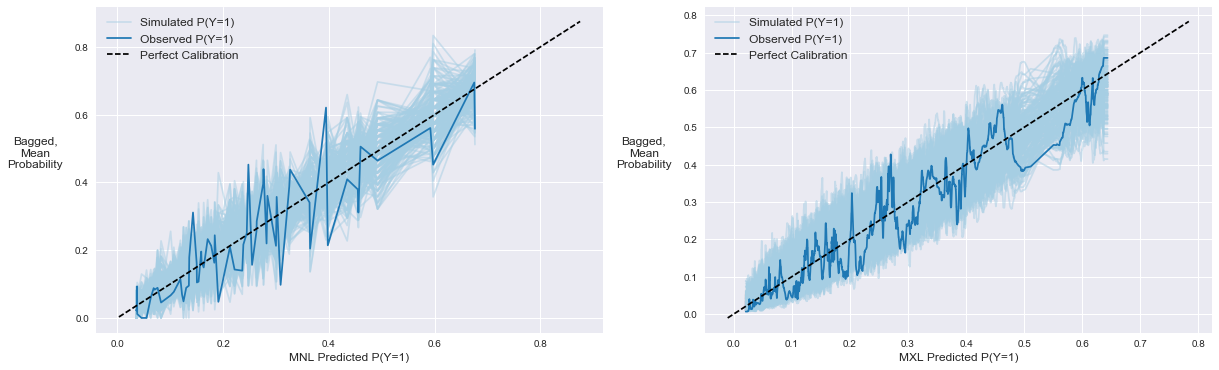

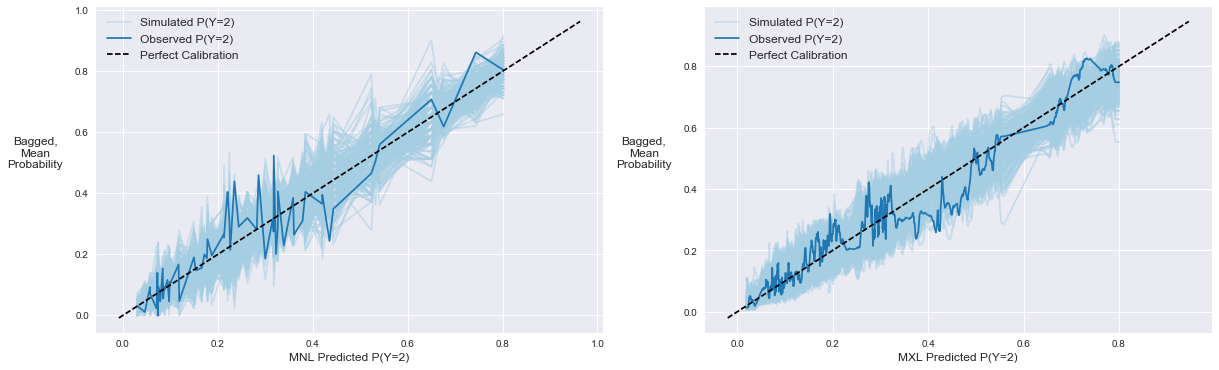

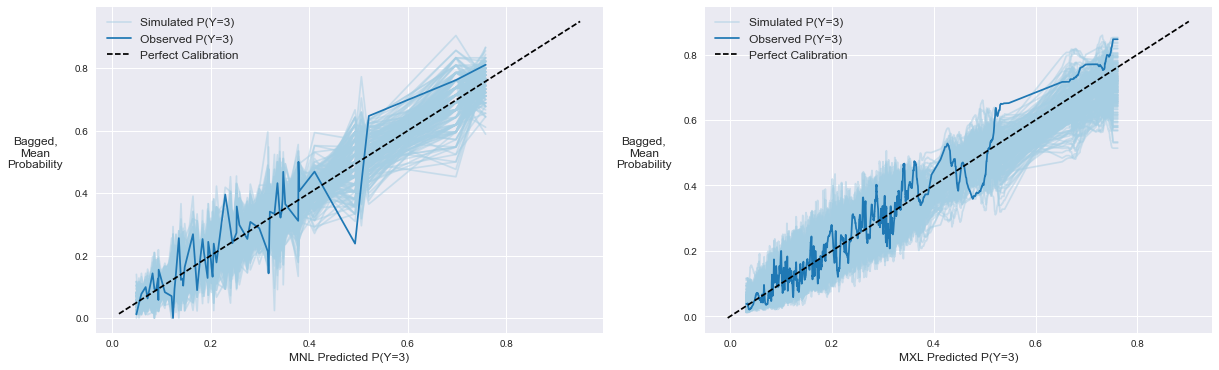

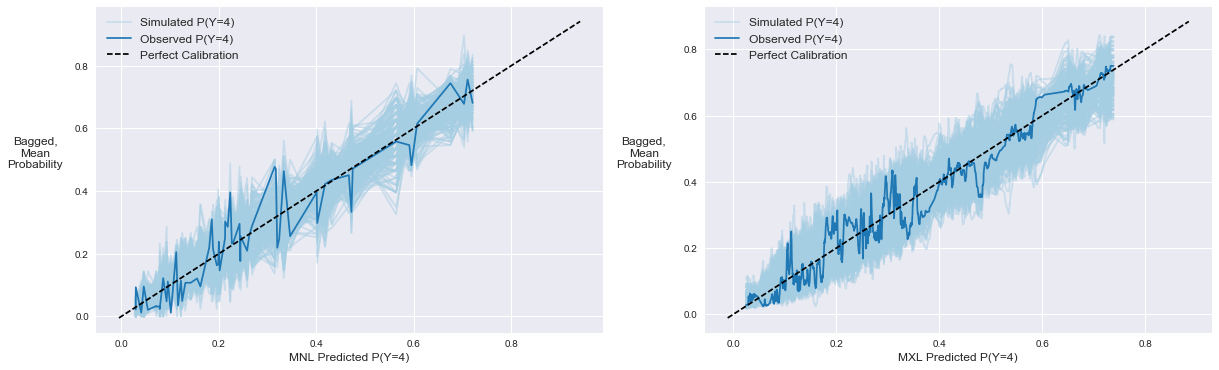

In [16]:
# Create a list of alternatives to be cycled through
alt_list = list(range(1, 5))

for alt in alt_list:
    # Filter out the rows for the current alternative
    filter_idx = np.where((long_electricity.alt == alt).values)[0]

    # Create the figure and axes for the reliability plots
    fig, axes = plt.subplots(nrows=1,
                             ncols=2,
                             figsize=(20, 6))
    
    # Create the current label names
    base_label = 'P(Y={})'.format(alt)
    current_y_label = 'Observed ' + base_label
    current_prob_label = 'Simulated ' + base_label
    
    # Populate the figures
    for pos, key in enumerate(sim_dict):
        # Get the current axis
        ax = axes[pos]
        
        # Get the current simulated y values
        current_sim_y = sim_dict[key][filter_idx, :]
        
        # Get the current probabilities
        current_probs = prob_dict[key][filter_idx]
        
        # Get the current observed choices
        current_choices = choice_dict[key][filter_idx]
        
        # Create the current x-label
        current_x_label = key + ' Predicted ' + base_label

        # Create the reliability plot
        make_bagged_marginal_model_plot(current_sim_y,
                                        current_choices,
                                        current_probs,
                                        fig_and_ax=[fig, ax],
                                        y_label=current_y_label,
                                        prob_label=current_prob_label,
                                        x_label=current_x_label,
                                        alpha=0.5,
                                        show=False,
                                        output_file=None)

        # Create the dashed reference line
        # Determine the maximum value of the x-axis or y-axis
        max_ref_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
        min_ref_val = max(ax.get_xlim()[0], ax.get_ylim()[0])
        # Determine the values to use to plot the reference line
        ref_vals = np.linspace(min_ref_val, max_ref_val, num=100)
        # Plot the reference line as a black dashed line
        ax.plot(ref_vals, ref_vals,
                'k--', label='Perfect Calibration')

        # Create the legend
        ax.legend(loc='best', fontsize=12)

    # Show the figure
    fig.show()

## Marginal Model Plots

Plotting: 100%|██████████| 200/200 [00:27<00:00,  7.30it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 200/200 [00:27<00:00,  7.19it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 200/200 [00:27<00:00,  7.62it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 200/200 [00:28<00:00,  7.53it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: Us

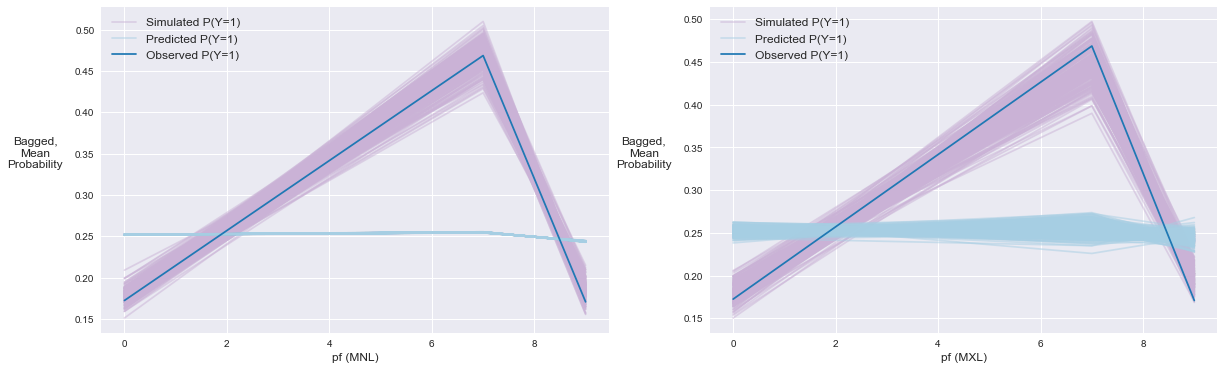

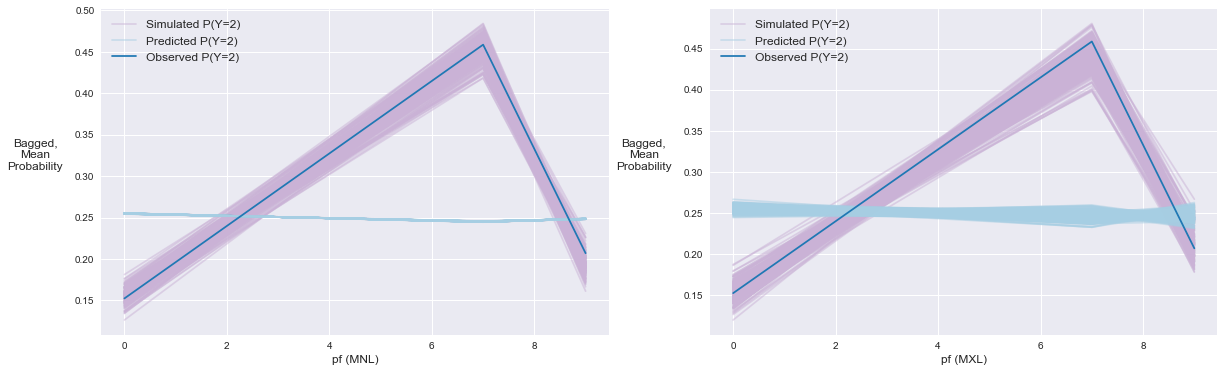

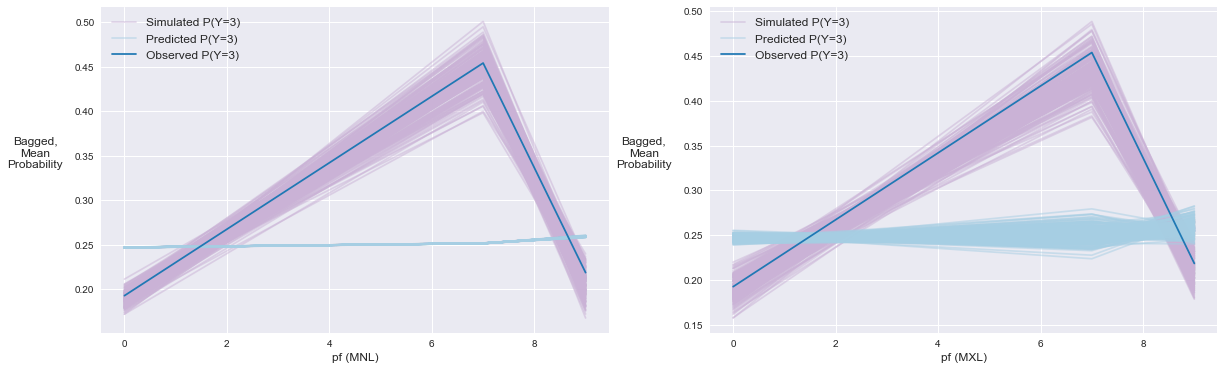

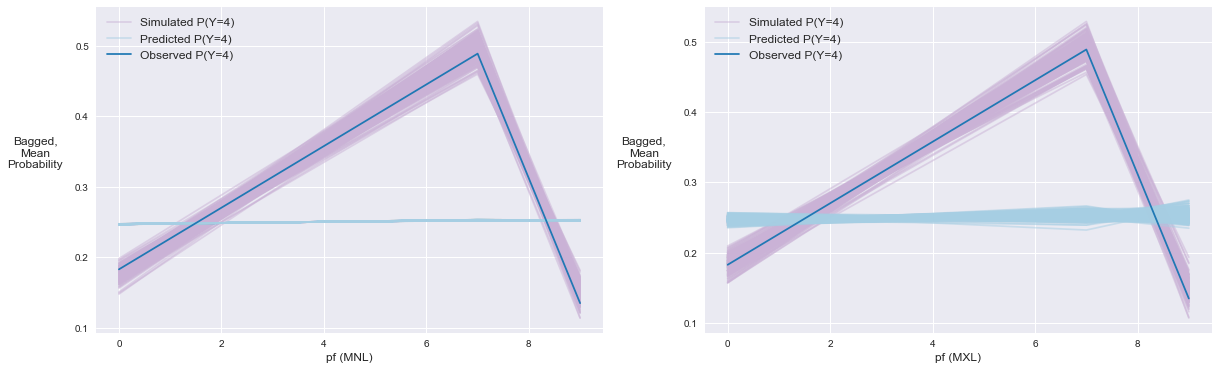

In [17]:
# Create a list of alternatives to be cycled through
alt_list = list(range(1, 5))

# Determine the variable to be checked in the
# marginal model plot
current_variable = 'pf'

for alt in alt_list:
    # Filter out the rows for the first alternative
    filter_idx = np.where((long_electricity.alt == alt).values)[0]

    # Create the figure and axes for the reliability plots
    fig, axes = plt.subplots(nrows=1,
                             ncols=2,
                             figsize=(20, 6))
    
    # Create the current label names
    base_label = 'P(Y={})'.format(alt)
    current_y_label = 'Observed ' + base_label
    current_prob_label = 'Predicted ' + base_label
    current_sim_label = 'Simulated ' + base_label
    
    # Populate the figures
    for pos, key in enumerate(sim_dict):
        # Get the current axis
        ax = axes[pos]
        
        # Get the current simulated y values
        current_sim_y = sim_dict[key][filter_idx, :]
        
        # Get the current simulated probabilities
        current_probs = sim_prob_dict[key]
        
        # Get the current observed choices
        current_y = choice_dict[key][filter_idx]
        
        # Get the current values for the x-axis
        current_x =\
            long_electricity.loc[filter_idx,
                                 current_variable].values
        
        # Create the current x-label
        current_x_label = '{} ({})'.format(current_variable, key)

        # Create the reliability plot
        make_bagged_marginal_model_plot(current_probs,
                                        current_y,
                                        current_x,
                                        sim_y=current_sim_y,
                                        fig_and_ax=[fig, ax],
                                        y_label=current_y_label,
                                        prob_label=current_prob_label,
                                        sim_label=current_sim_label,
                                        x_label=current_x_label,
                                        alpha=0.5,
                                        show=False,
                                        output_file=None)

        # Create the legend
        ax.legend(loc='best', fontsize=12)

    # Show the figure
    fig.show()

### Simulated histograms

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matp

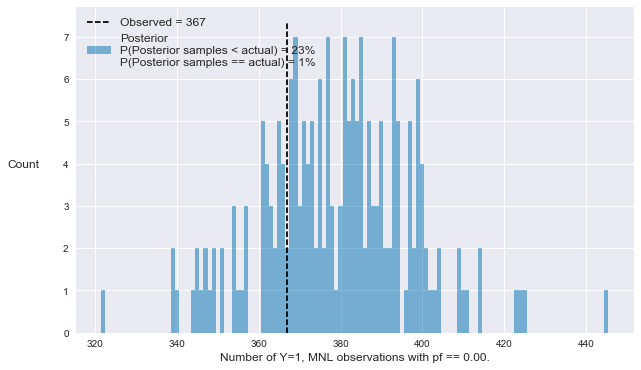

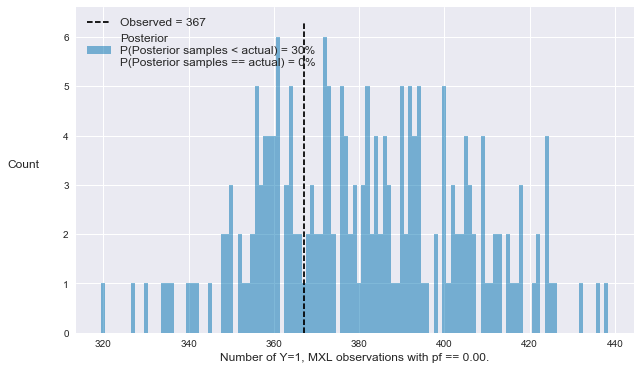

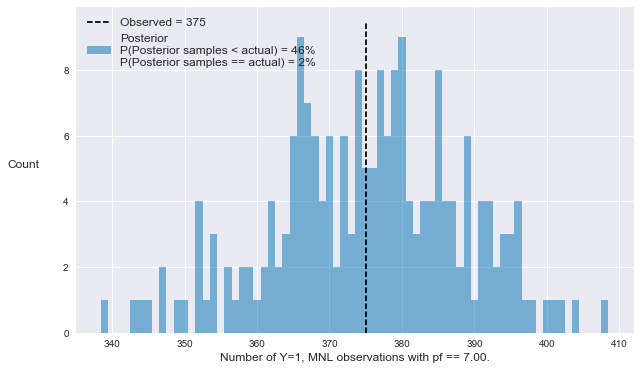

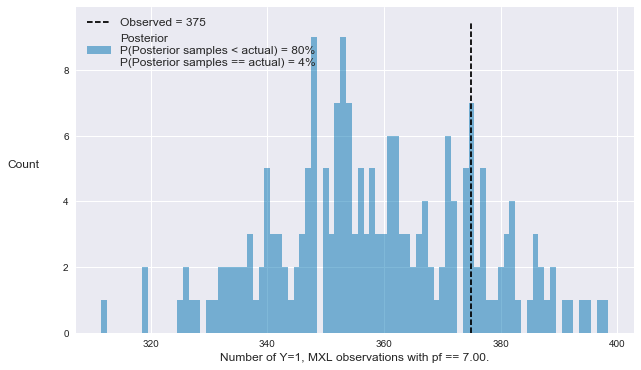

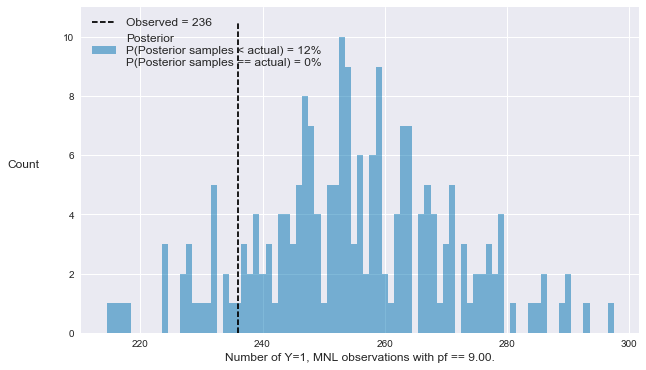

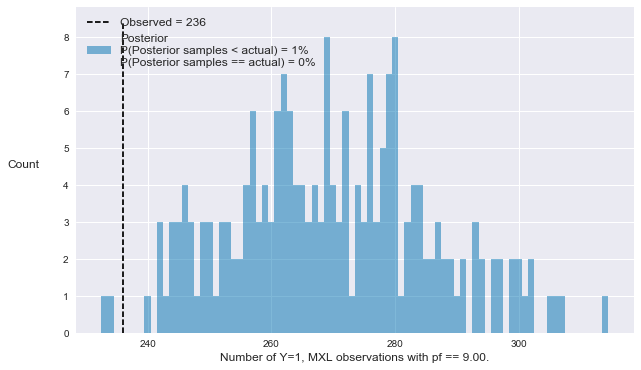

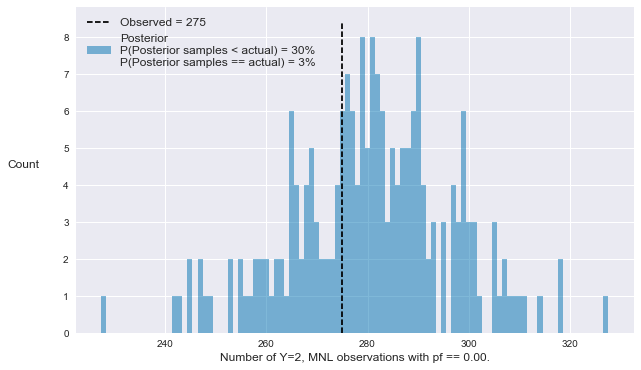

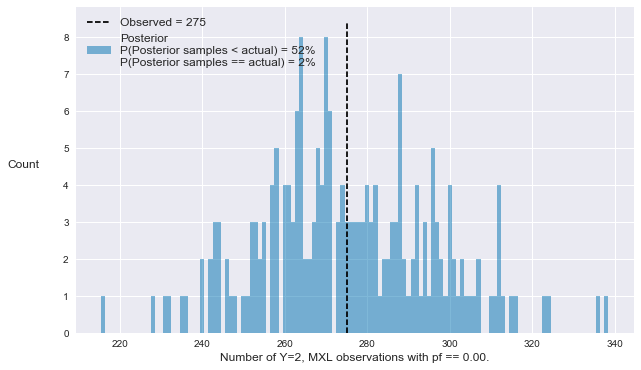

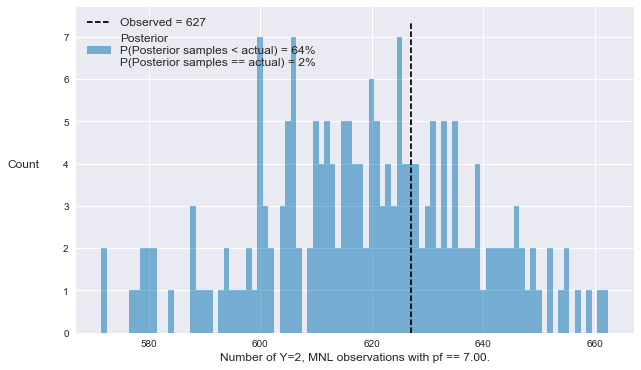

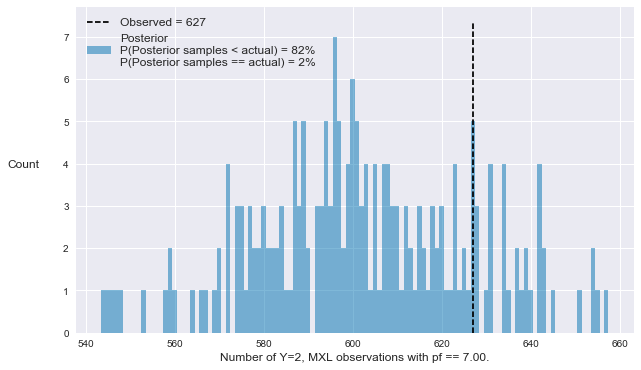

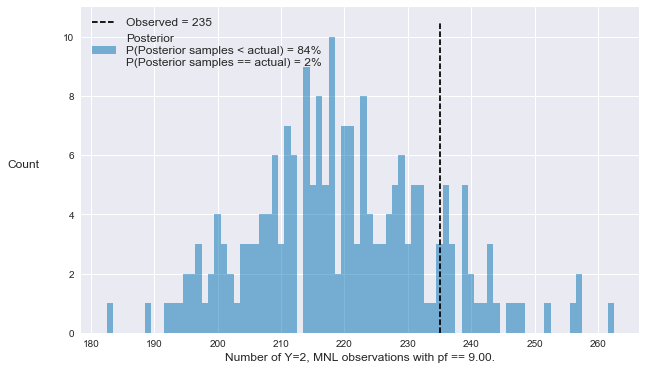

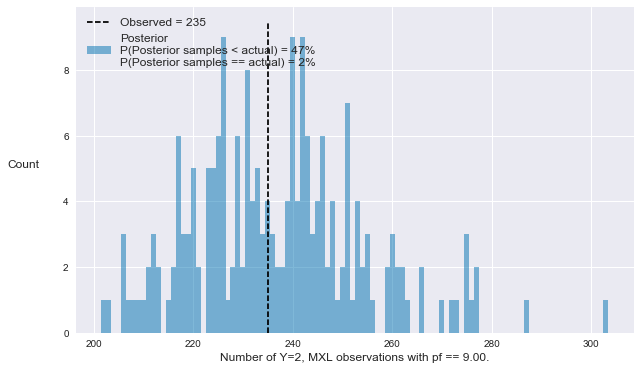

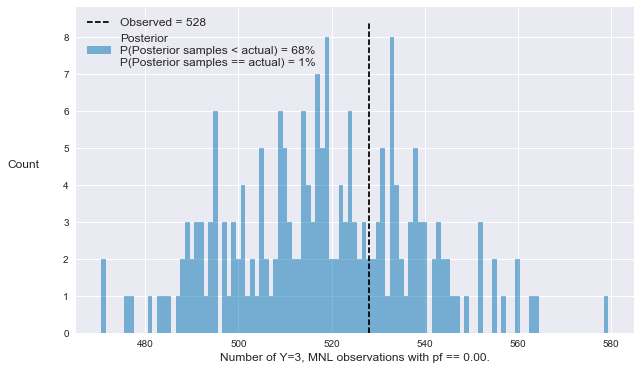

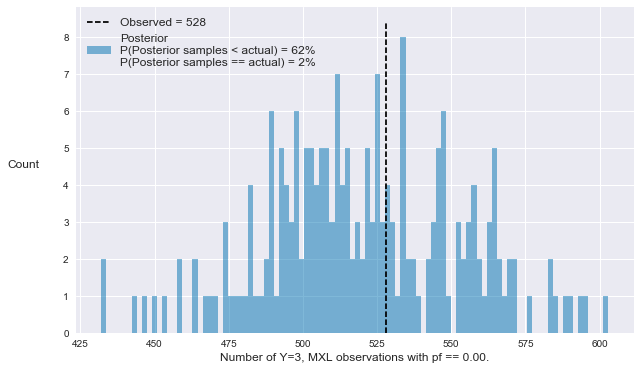

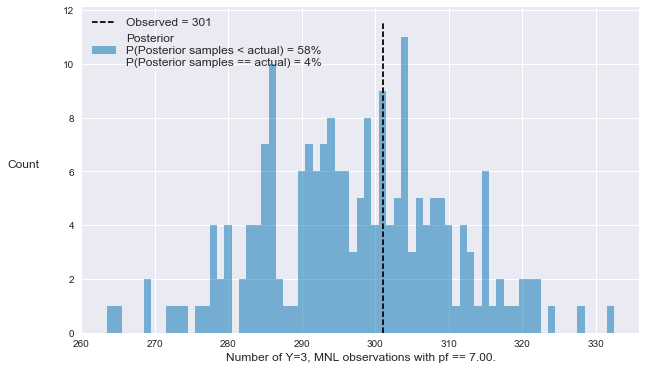

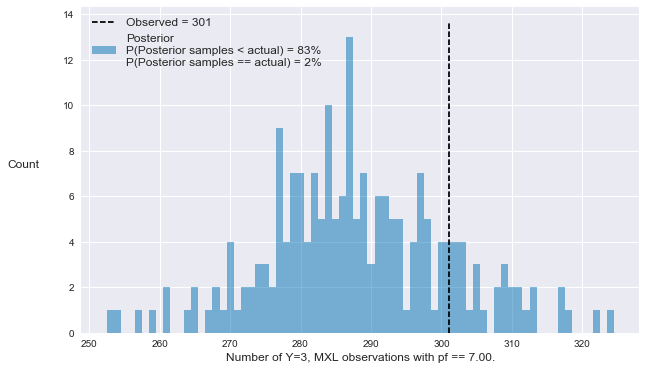

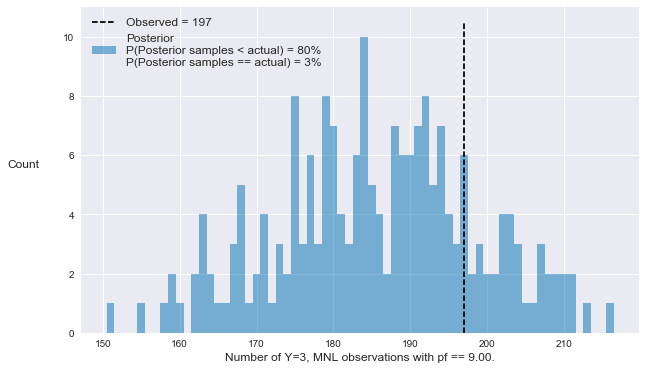

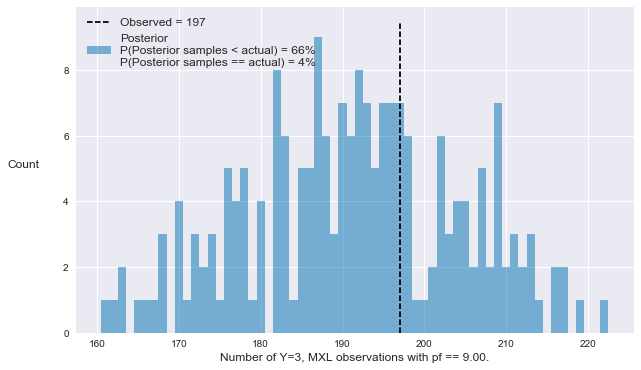

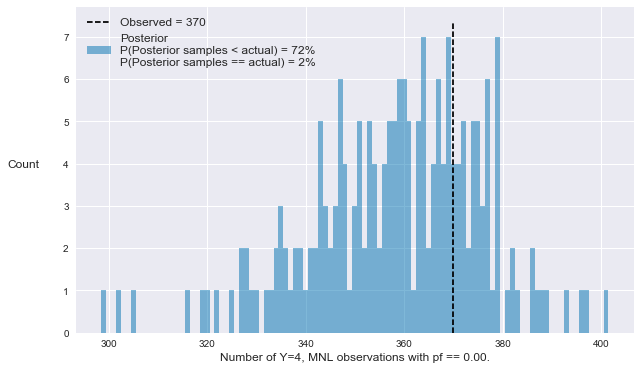

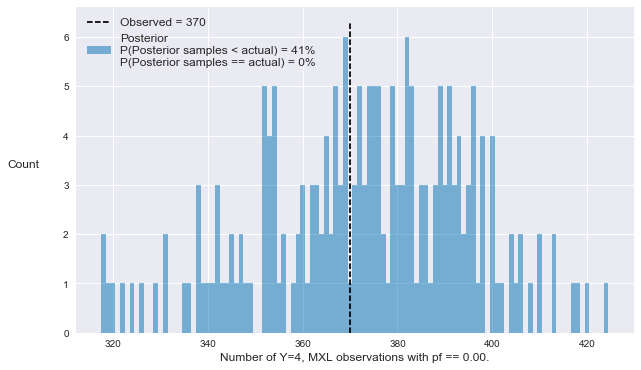

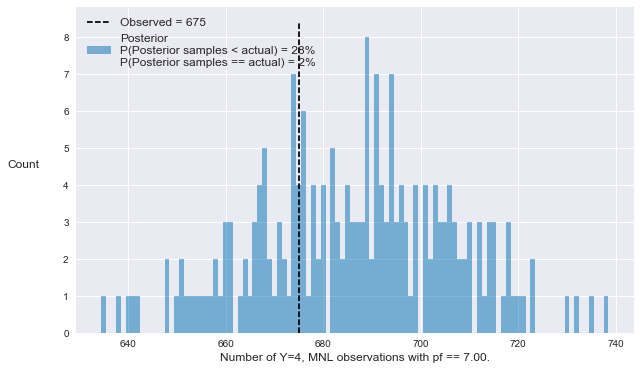

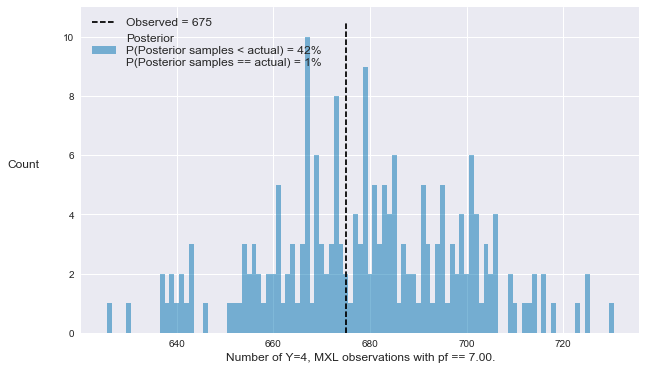

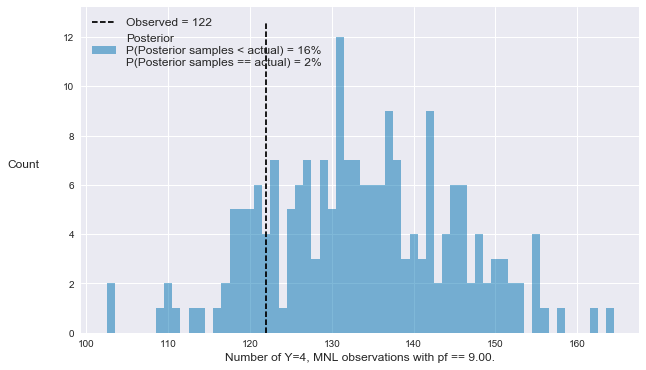

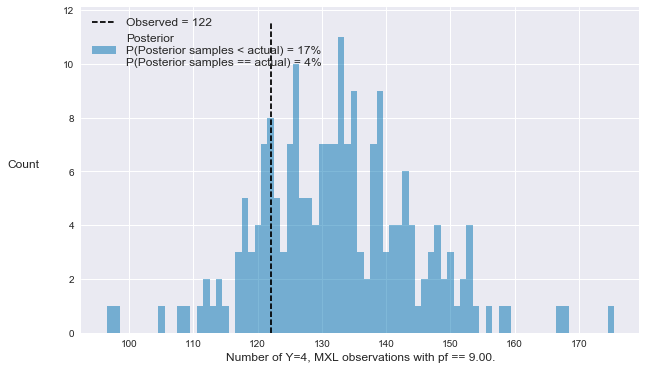

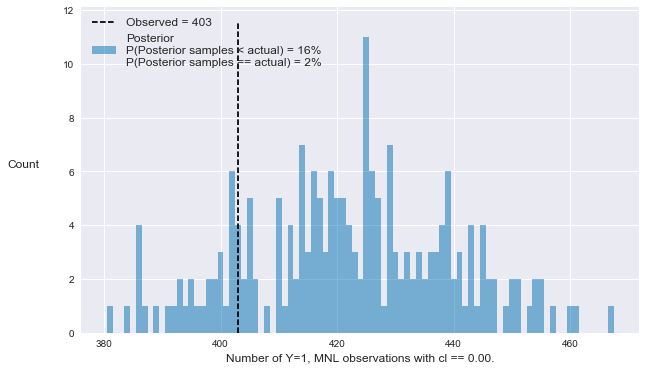

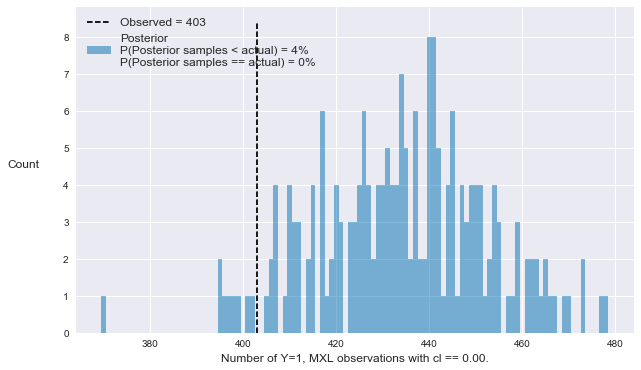

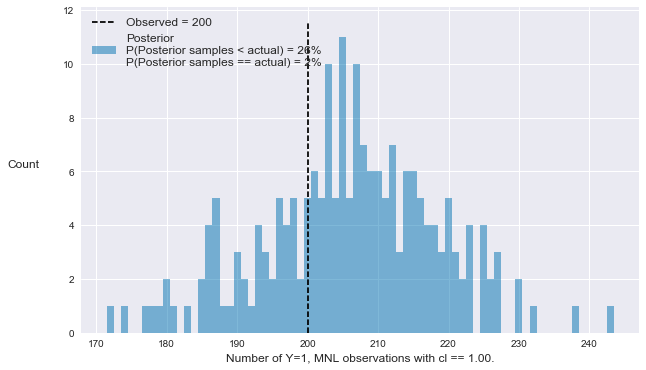

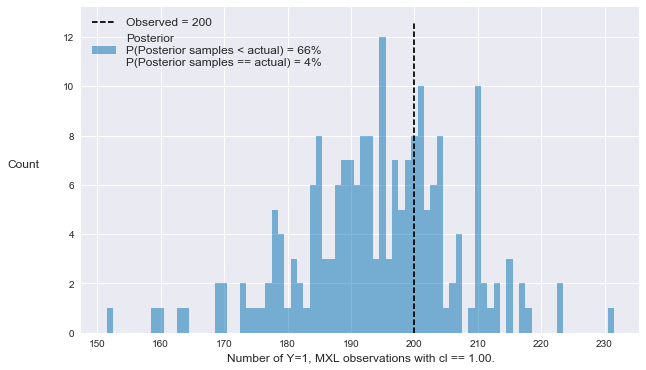

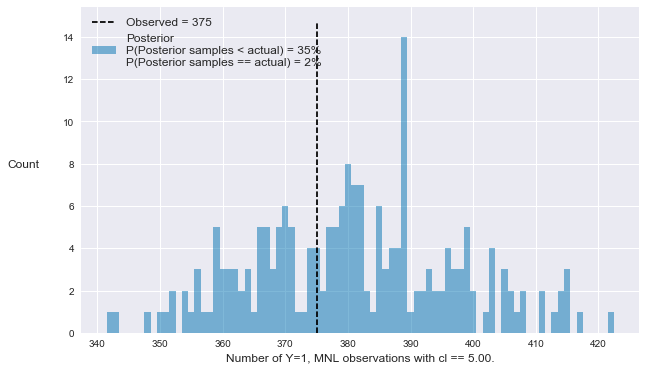

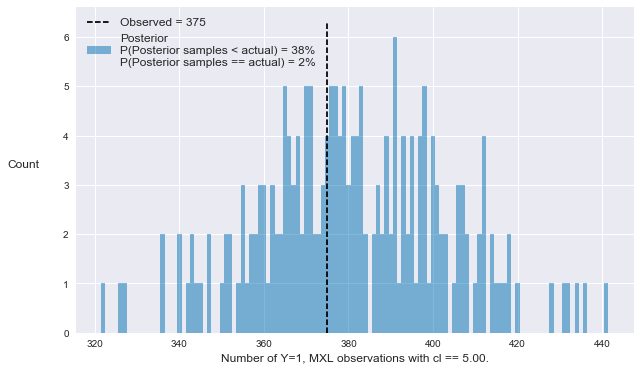

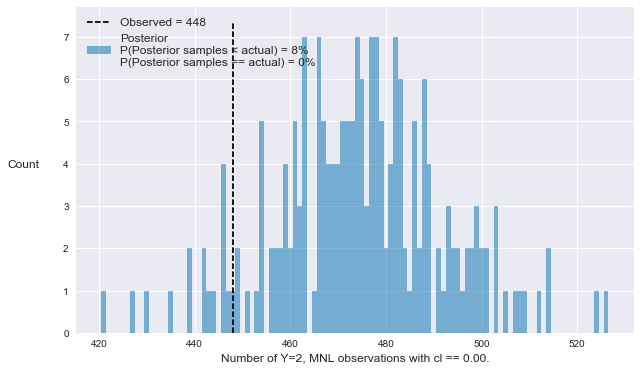

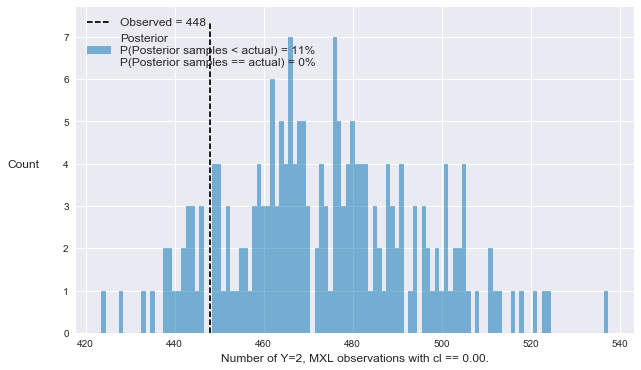

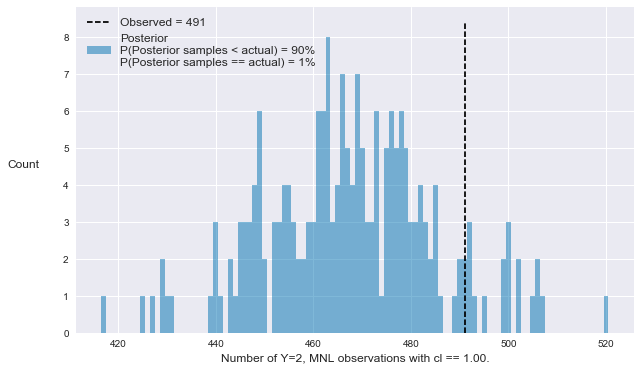

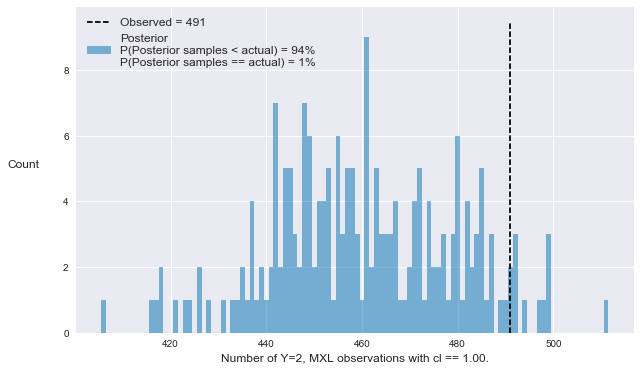

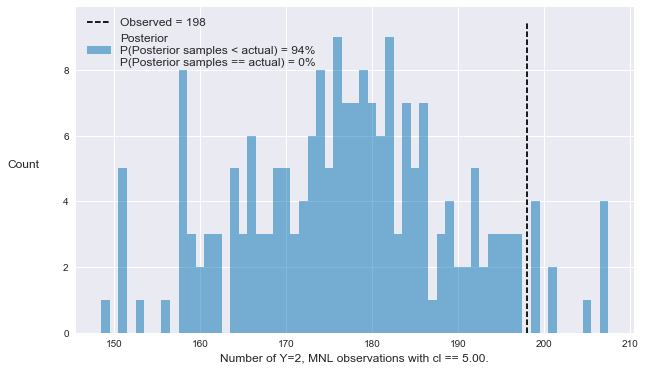

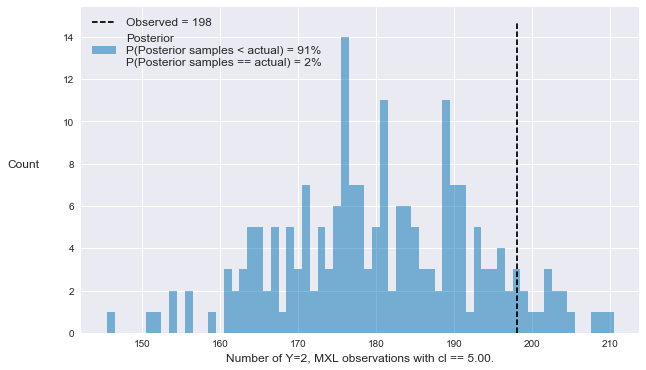

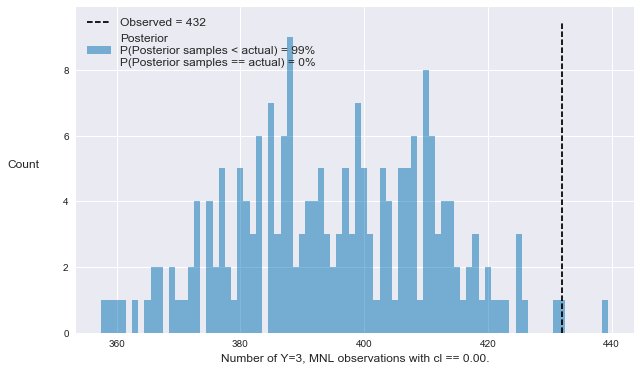

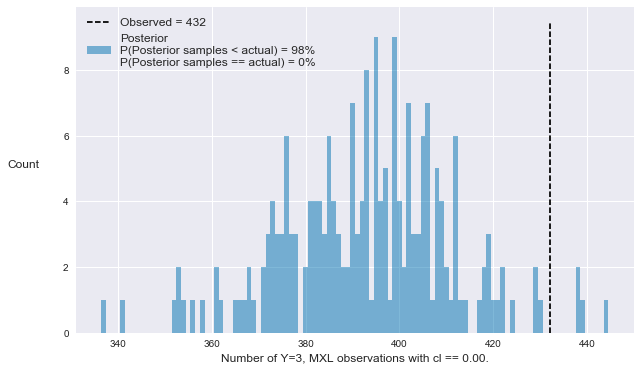

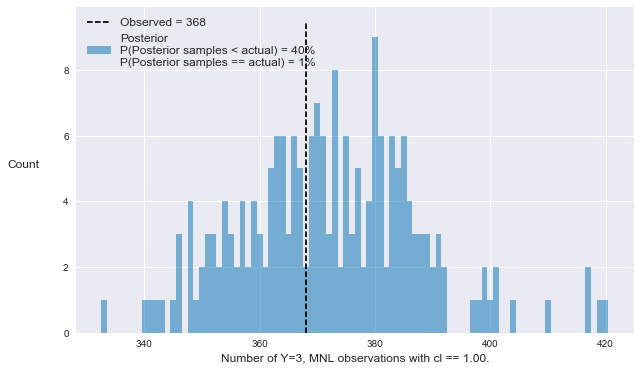

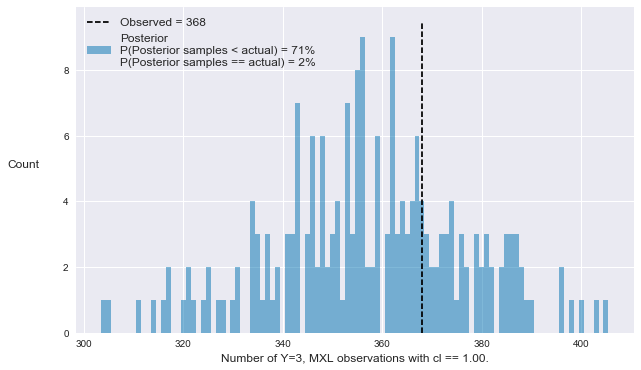

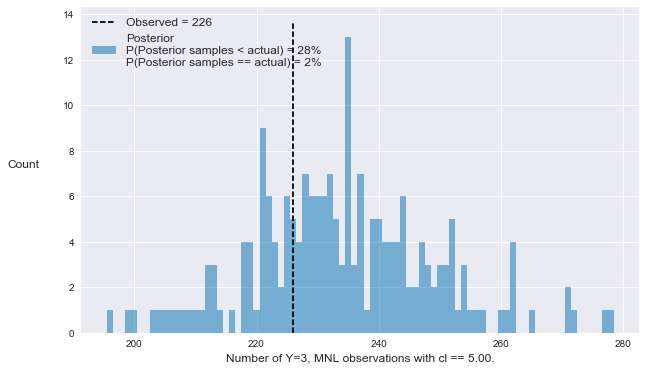

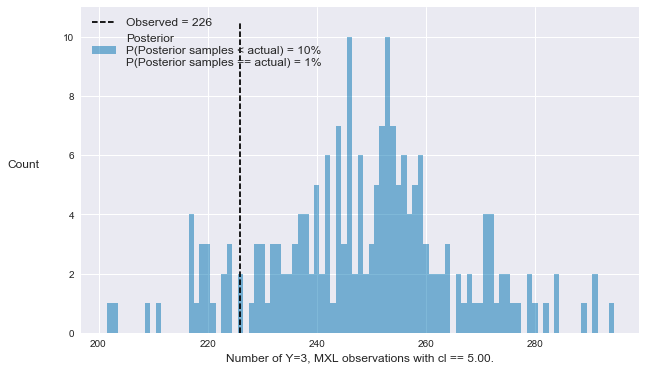

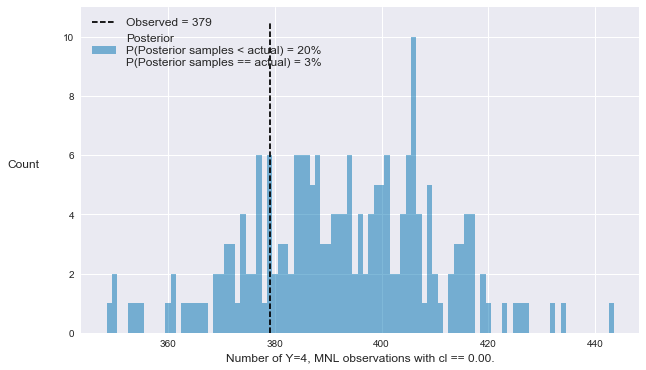

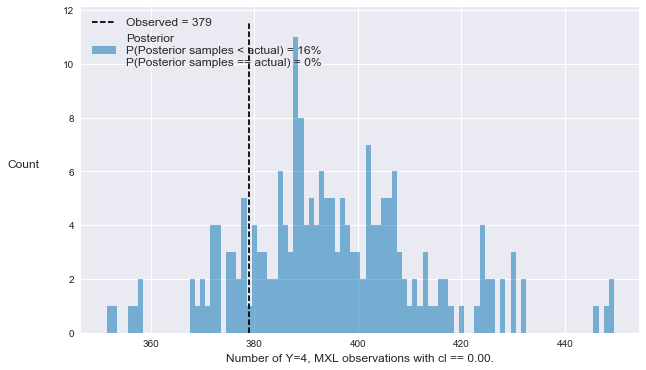

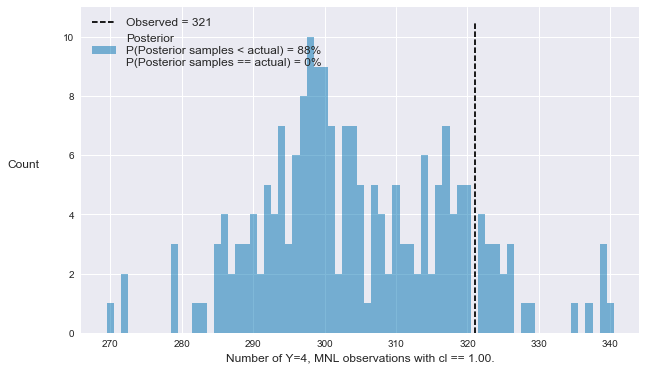

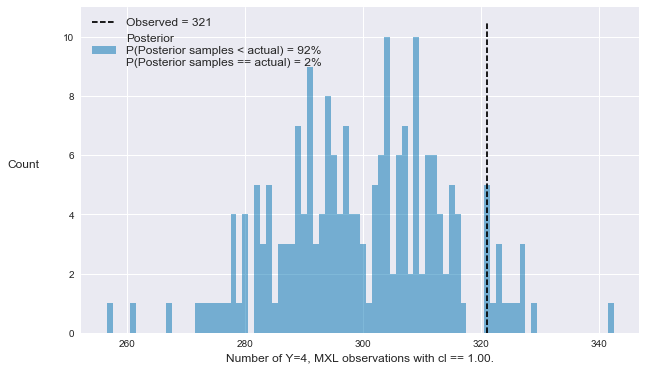

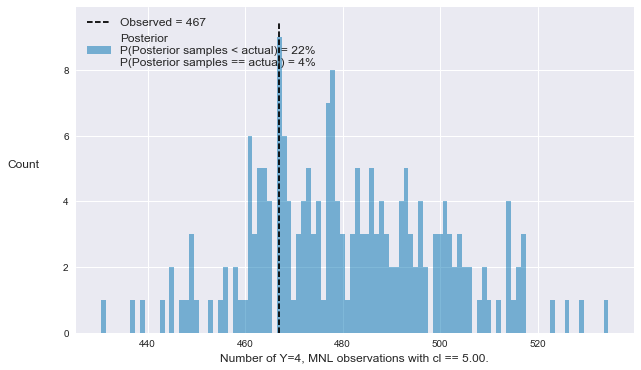

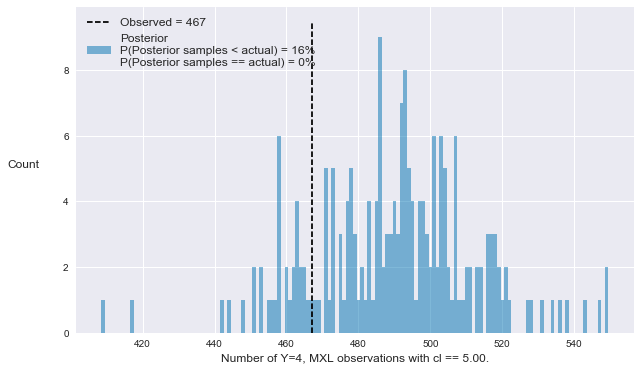

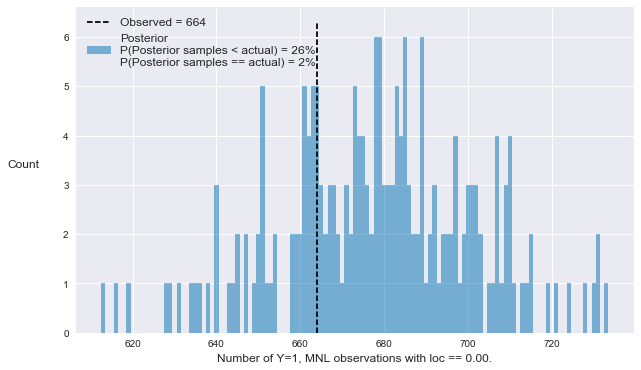

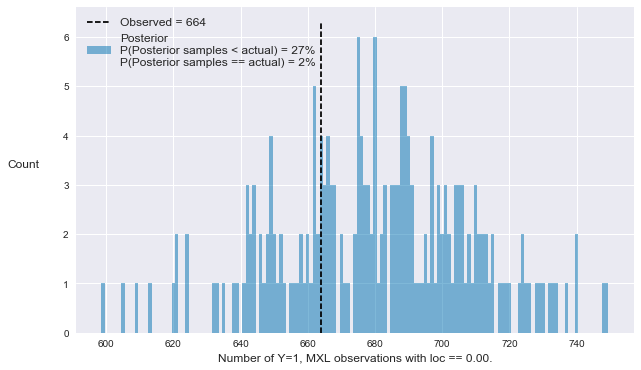

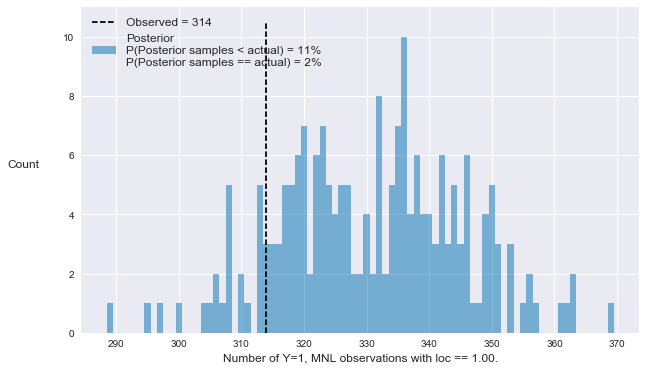

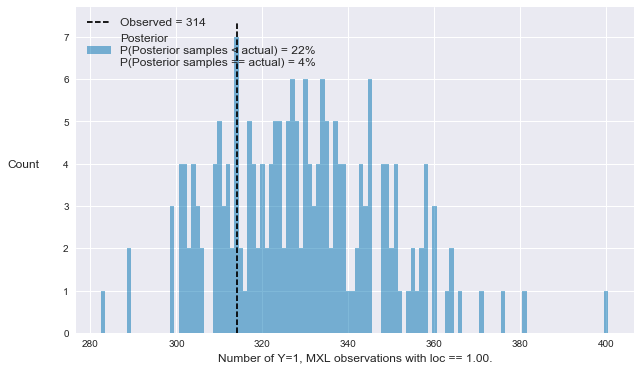

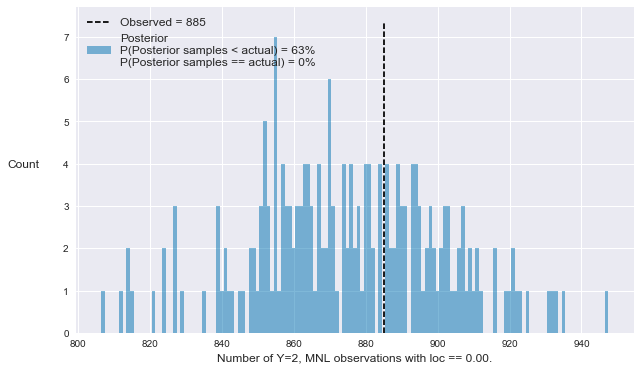

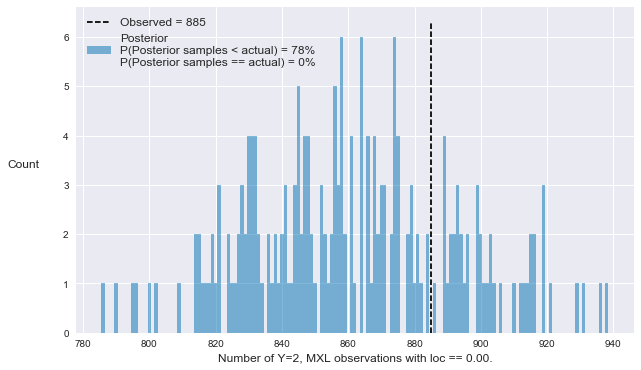

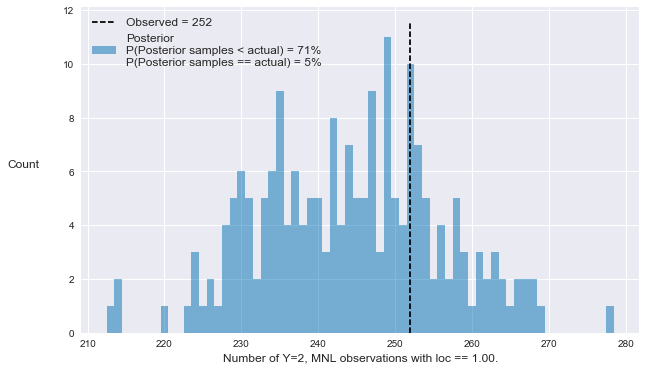

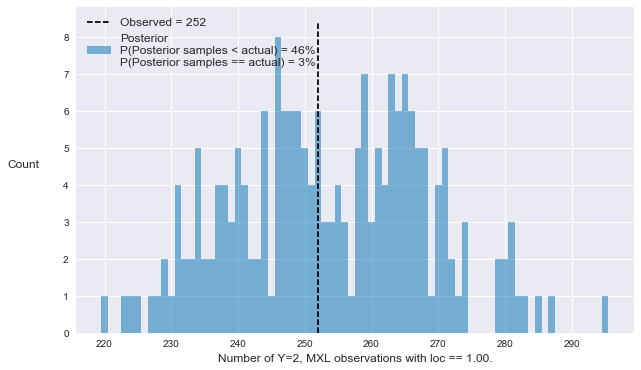

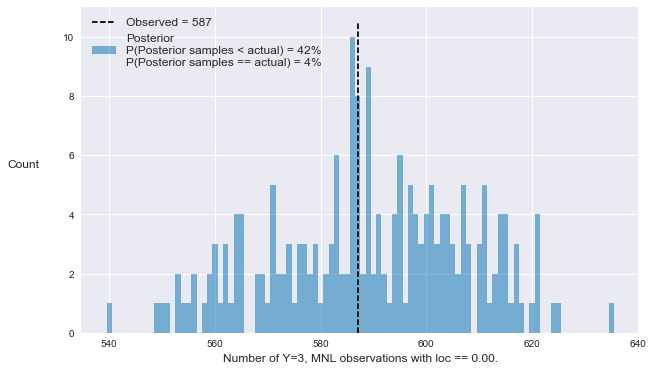

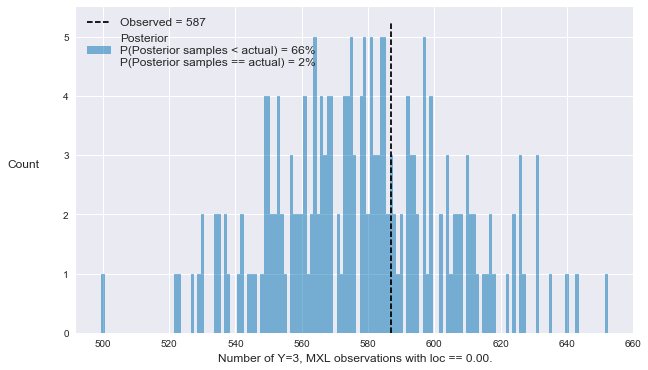

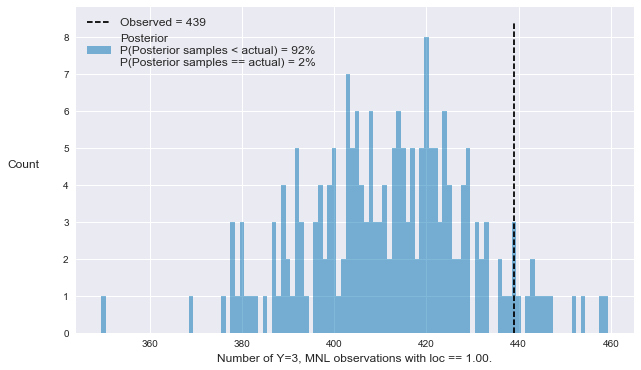

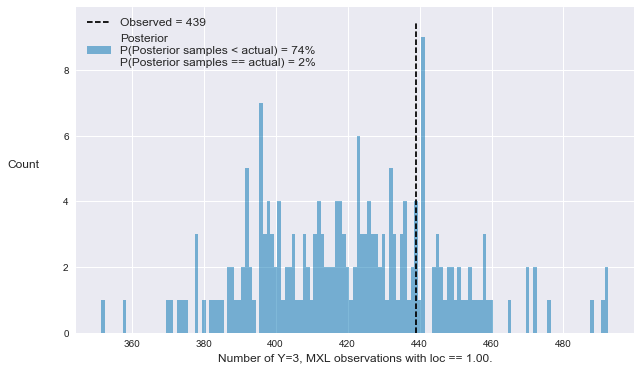

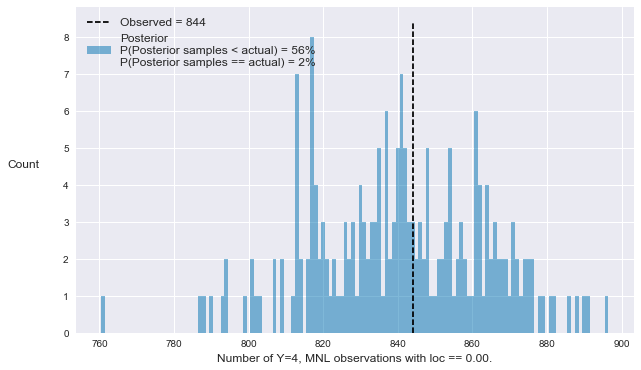

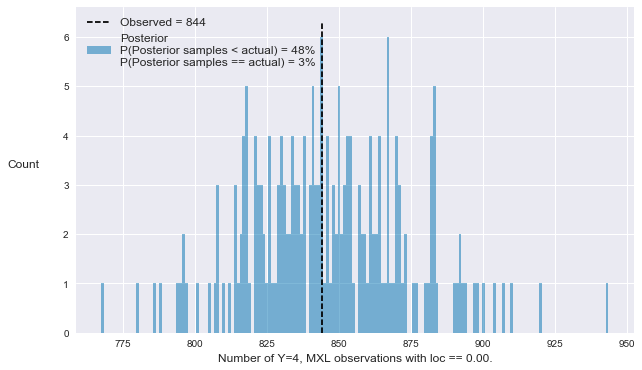

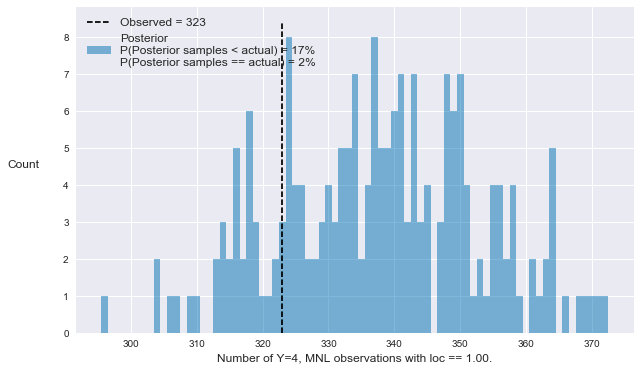

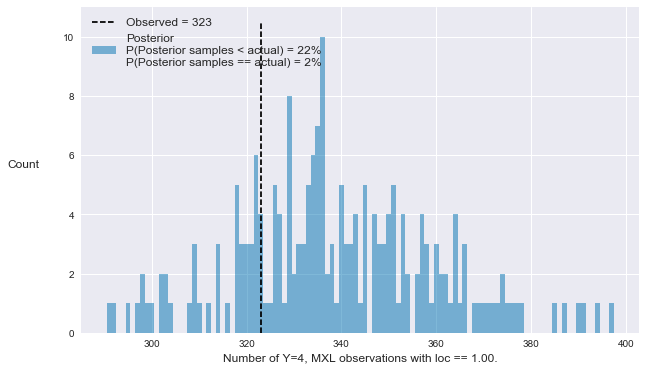

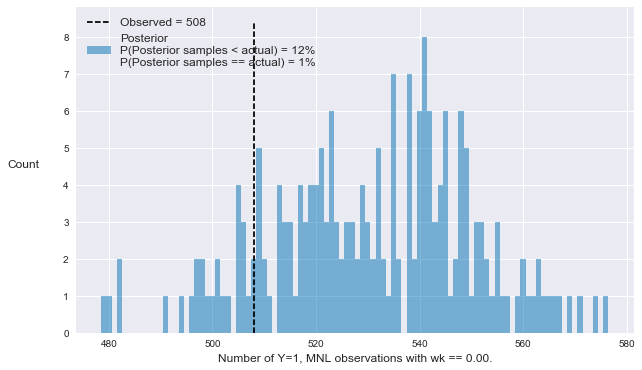

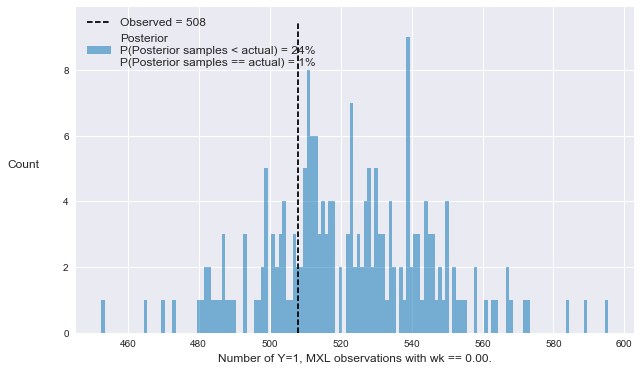

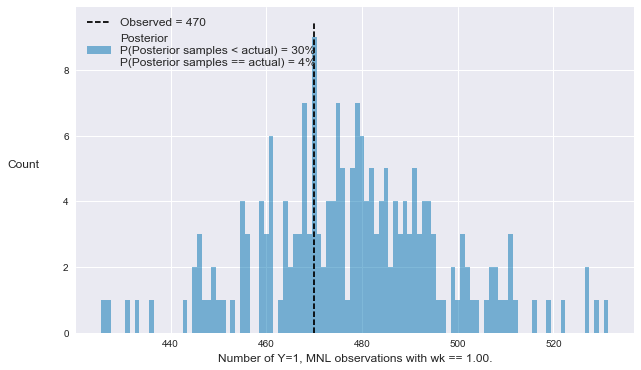

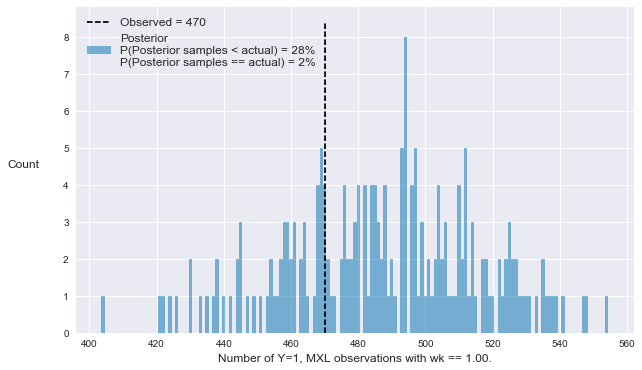

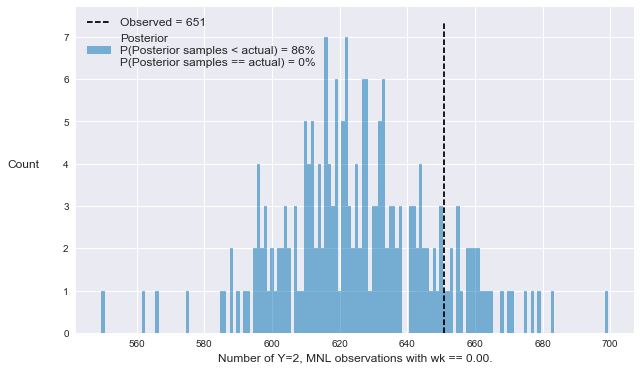

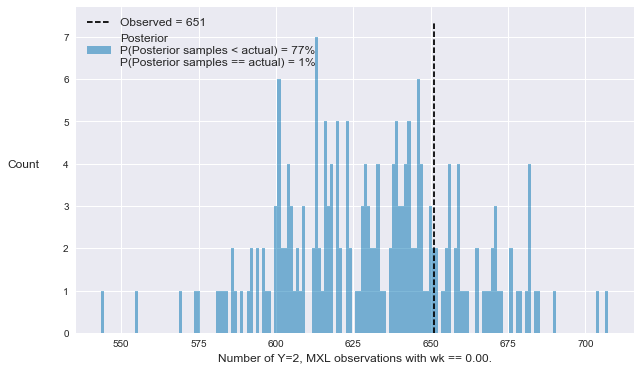

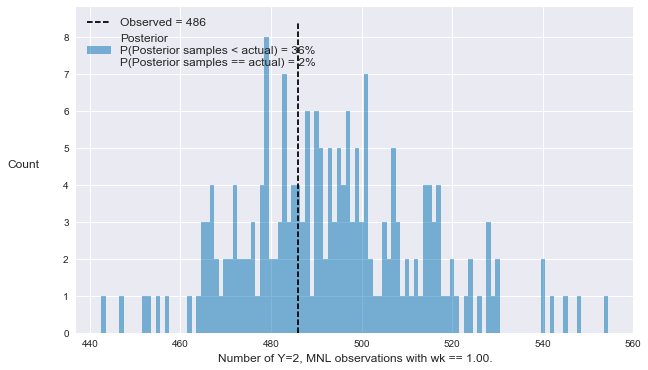

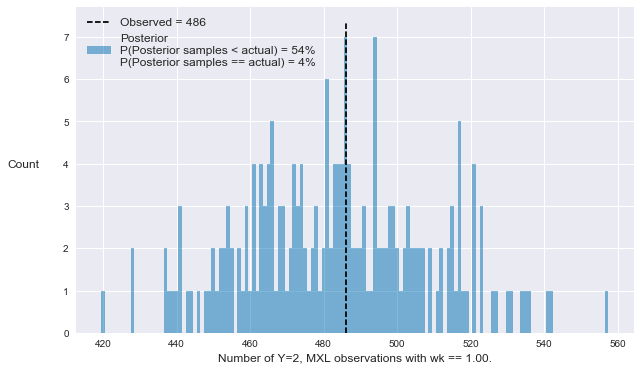

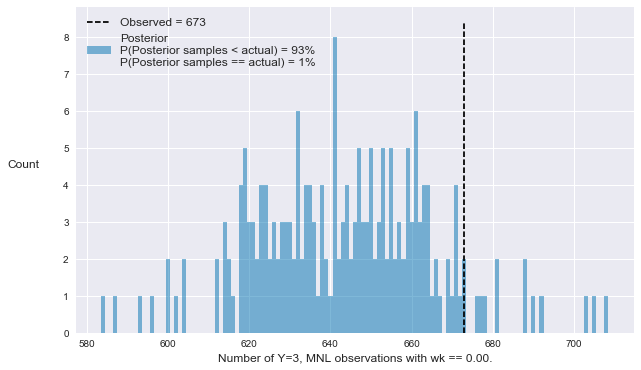

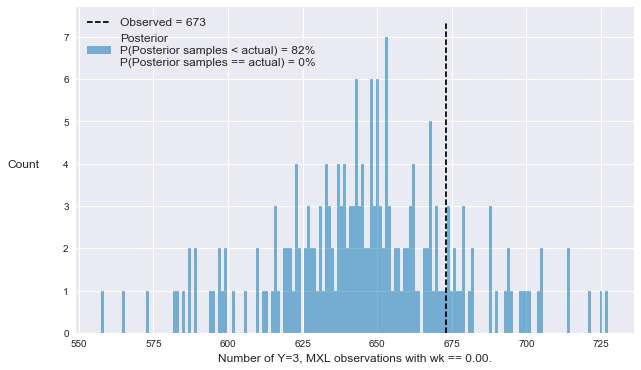

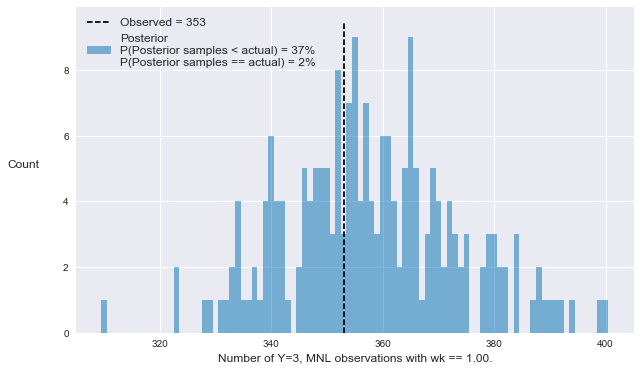

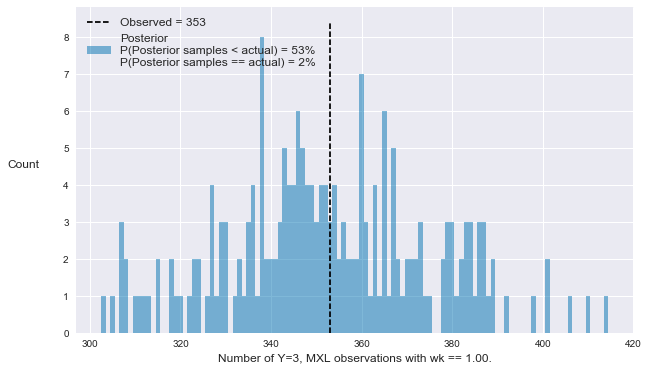

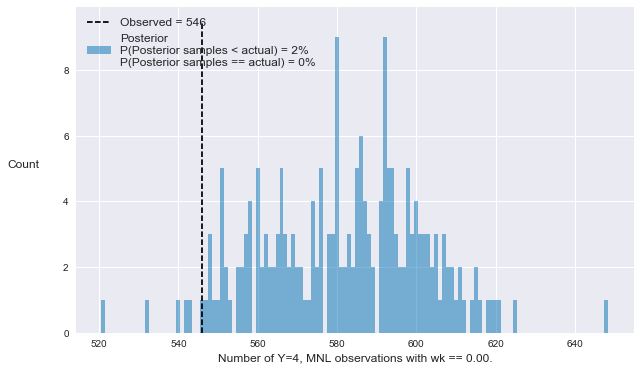

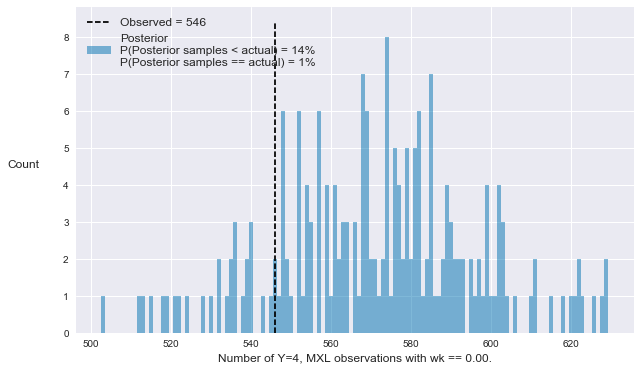

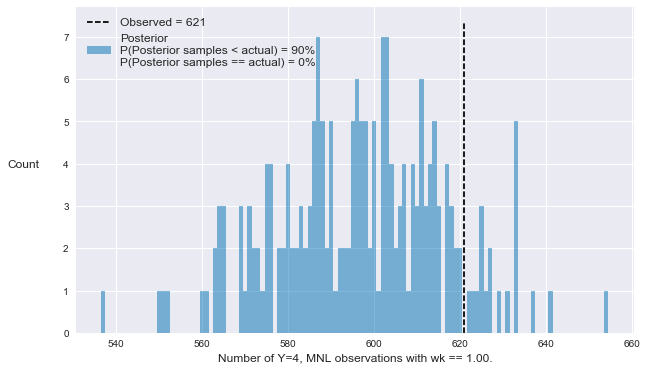

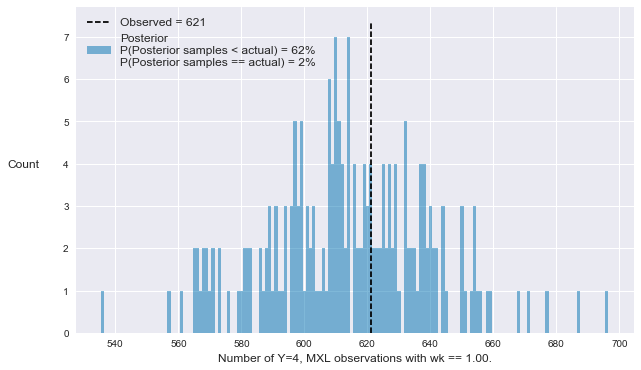

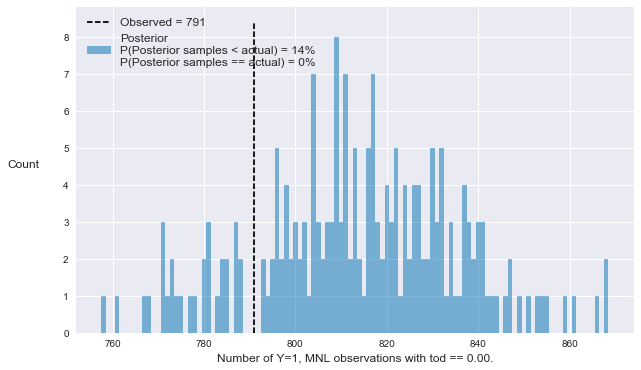

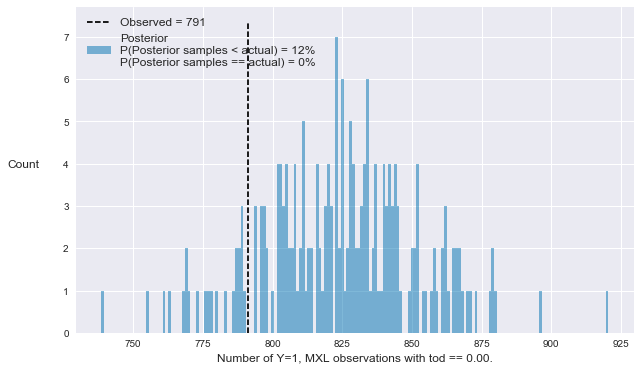

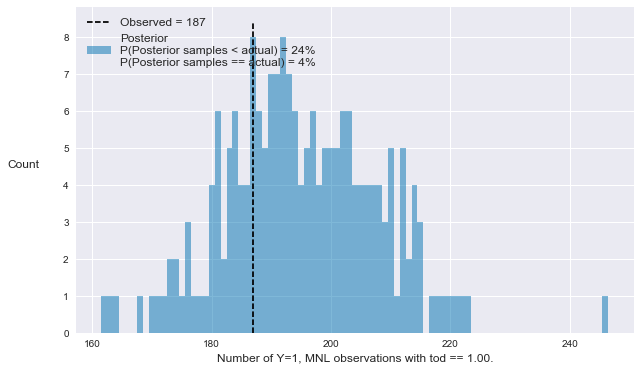

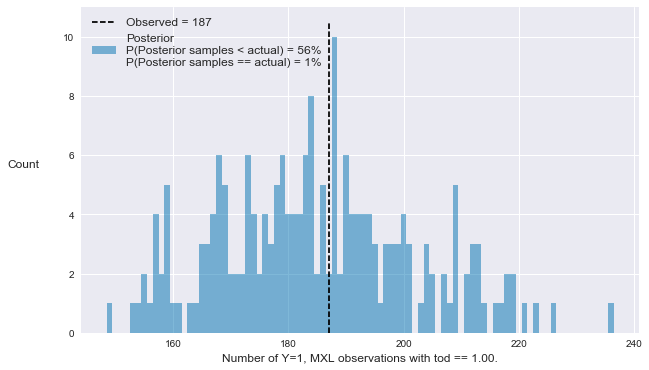

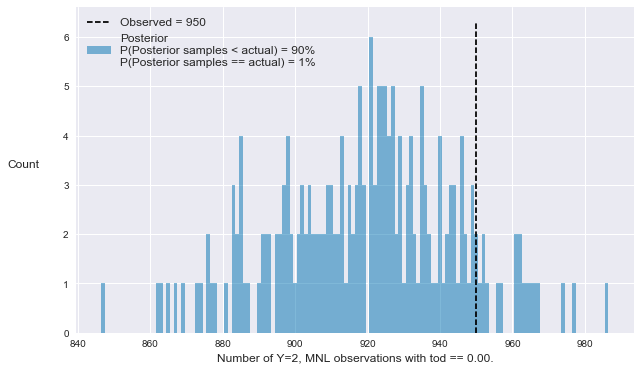

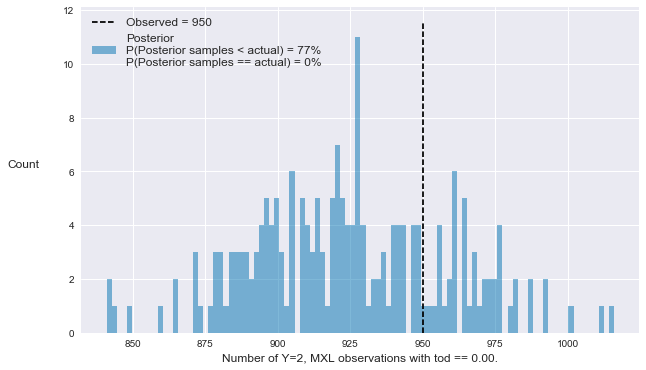

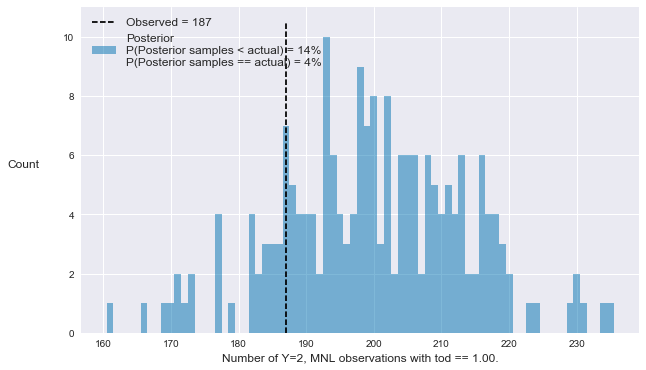

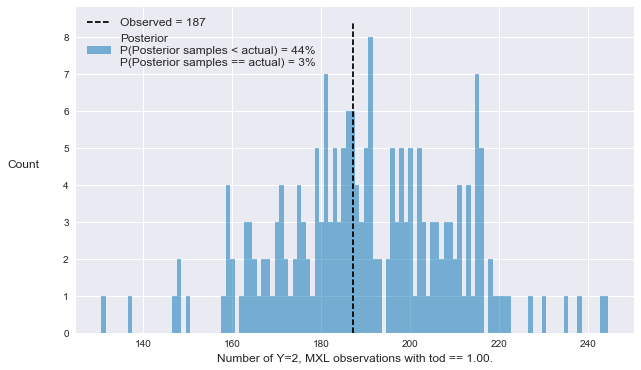

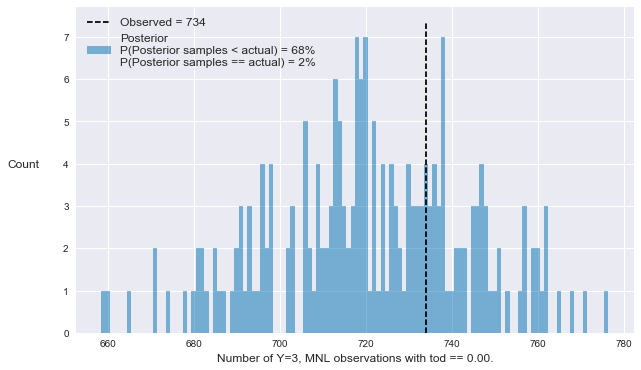

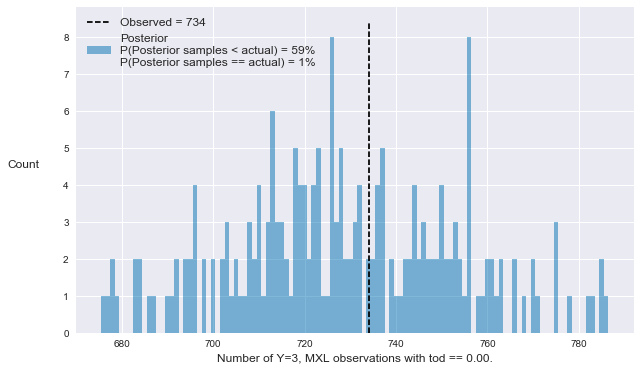

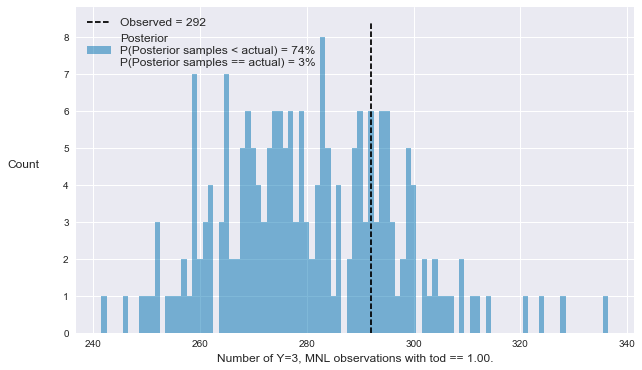

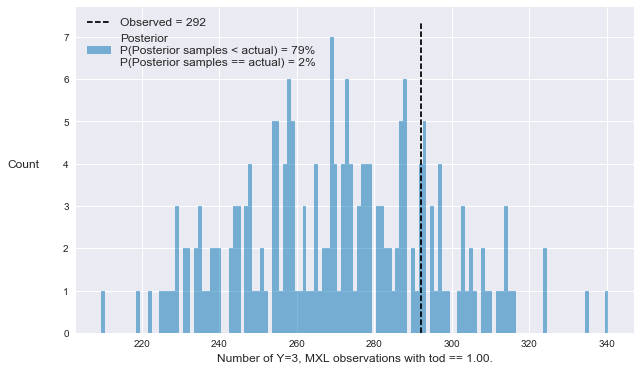

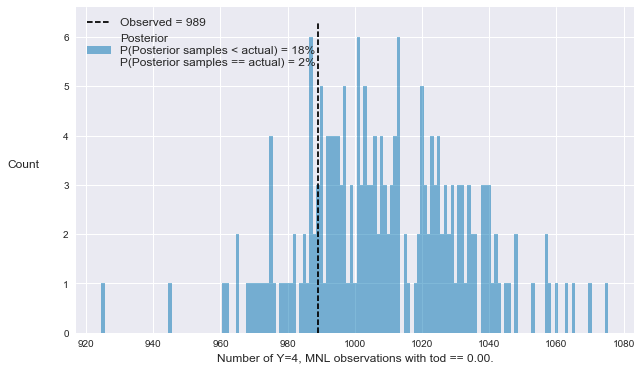

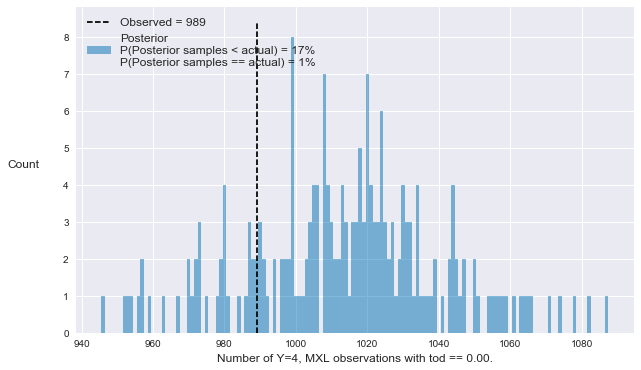

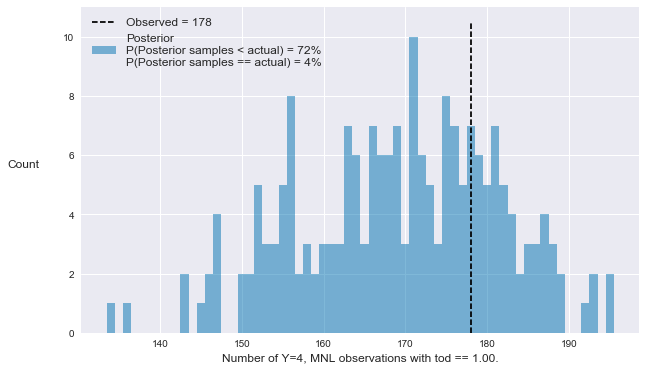

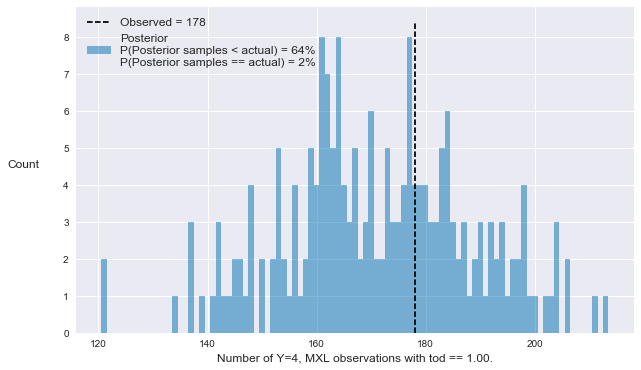

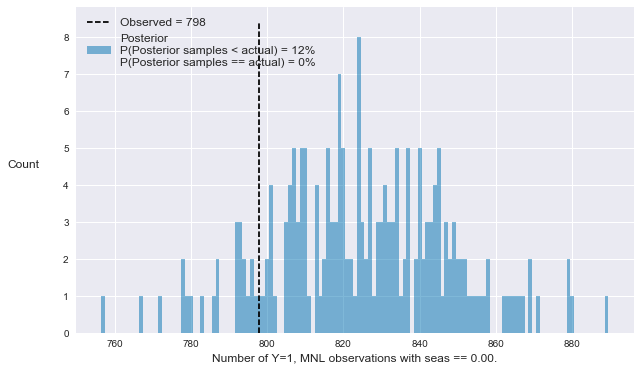

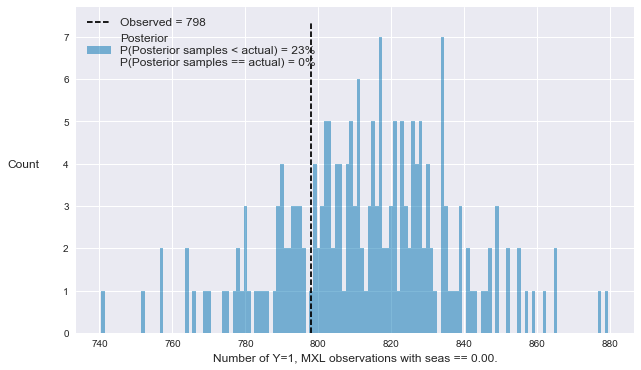

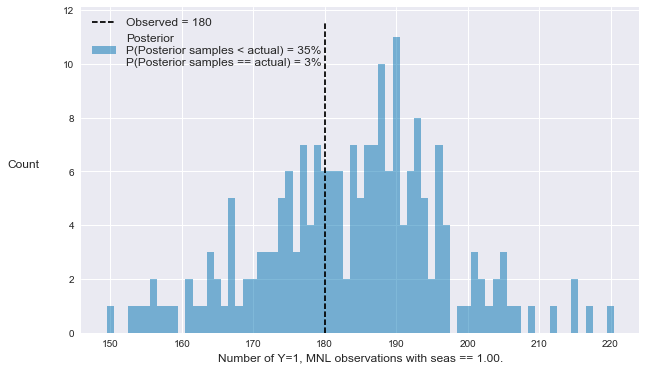

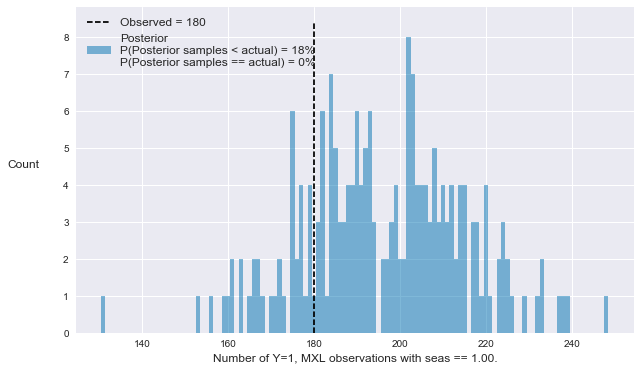

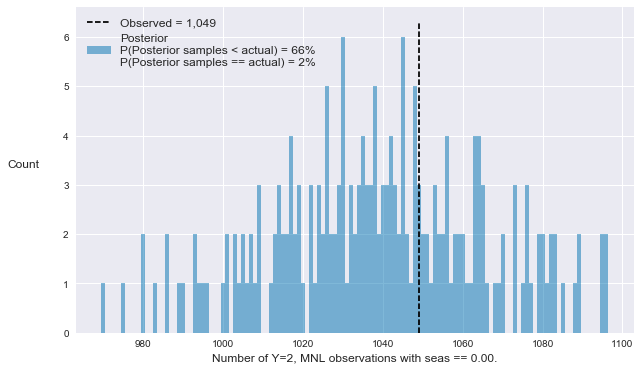

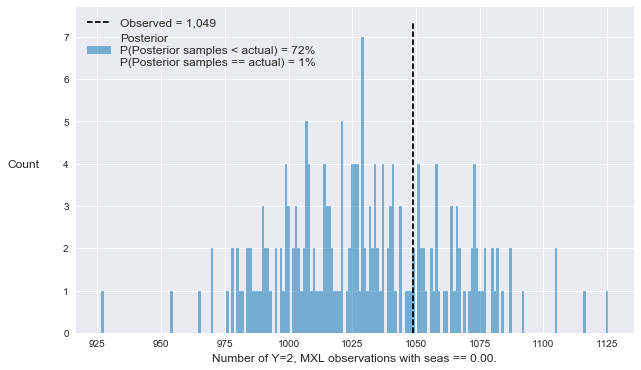

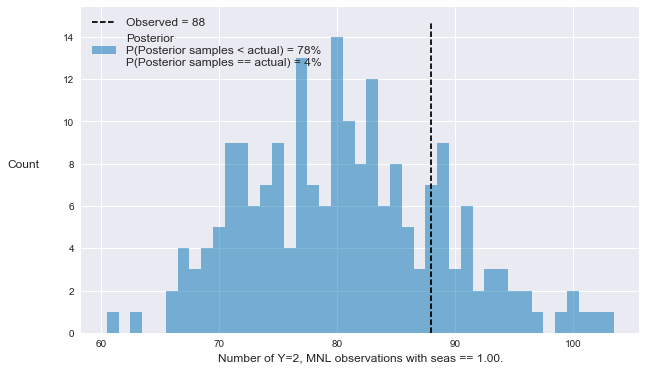

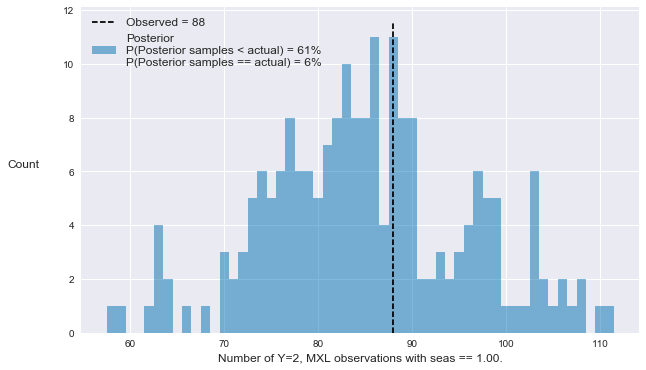

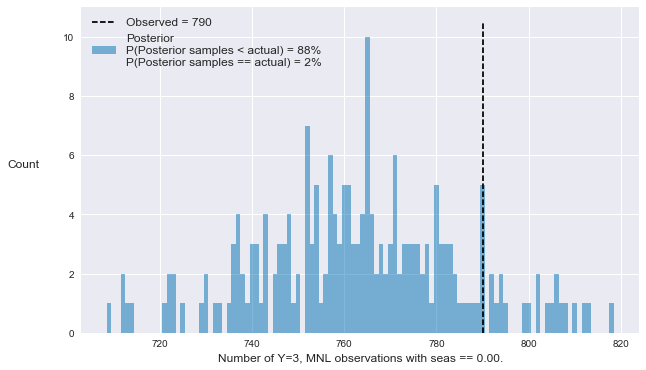

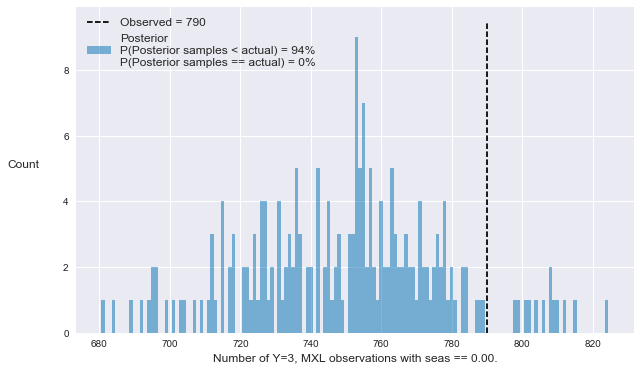

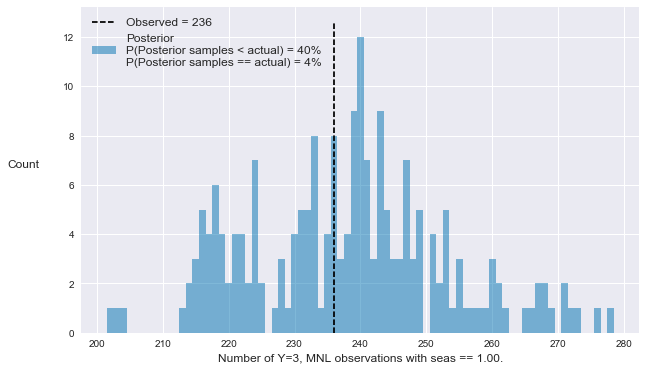

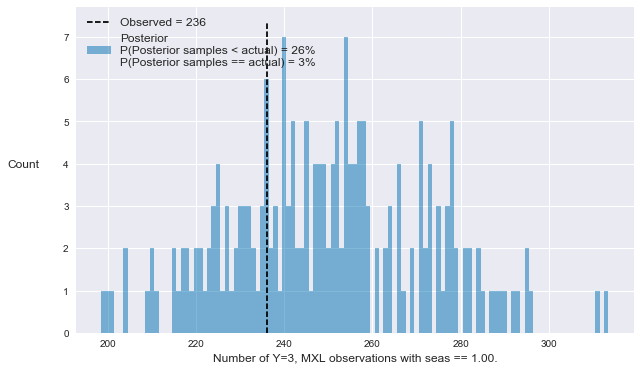

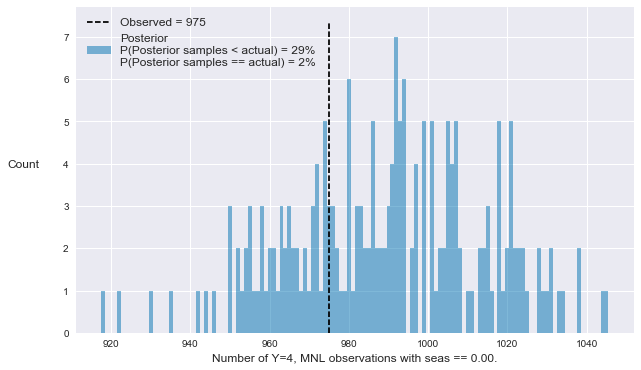

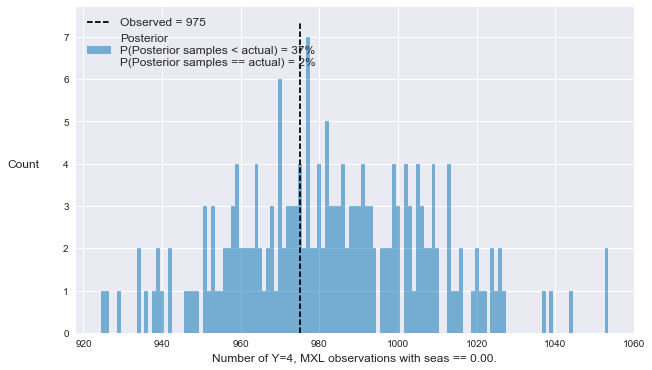

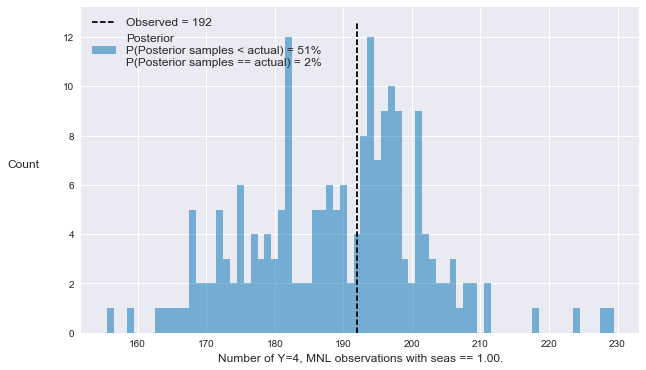

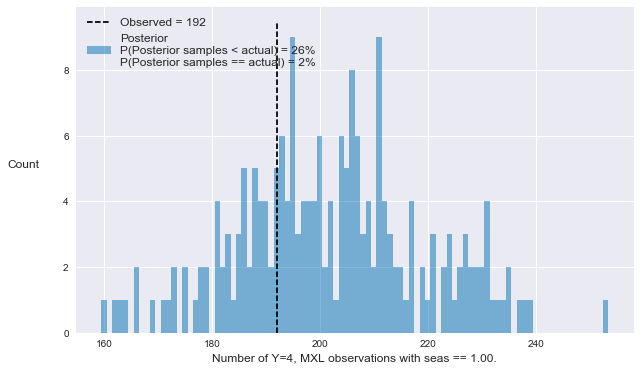

In [18]:
# Create a list of alternatives to be cycled through
alt_list = list(range(1, 5))

for current_variable in index_var_names:
    for alt in alt_list:
        possible_values =\
            np.sort(long_electricity.loc[long_electricity.alt == alt, 
                                         current_variable].unique())
            
        for current_value in possible_values:
            # Create the current label names
            base_label = 'Y={}'.format(alt)
            
            # Populate the figures
            for pos, key in enumerate(sim_dict):
                # Get the current simulated y values without filtering
                current_sim_y = sim_dict[key]

                # Get the current observed choices
                current_y = choice_dict[key]

                filter_row = ((long_electricity.alt == alt) &
                              (long_electricity[current_variable] == current_value))
                viz.plot_categorical_predictive_densities(
                    long_electricity,
                    None,
                    current_sim_y,
                    current_variable,
                    filter_row,
                    current_y,
                    filter_name=base_label + ', ' + key + ' observations',
                    post_color=sbn.color_palette('colorblind')[0],
                    figsize=(10, 6),
                    legend_loc='upper left',
                    show=False,
                    output_file=None)
            fig.show()

In [19]:
from sklearn.ensemble import (ExtraTreesClassifier,
                              ExtraTreesRegressor)

def make_bagger(X, Y,
                n_estimators=50,
                min_samples_leaf=10,
                random_state=None):
    if not isinstance(X, np.ndarray) or len(X.shape) != 1:
        msg = 'X MUST be a 1D ndarray'
        raise ValueError(msg)
    if not isinstance(Y, np.ndarray) or len(Y.shape) != 1:
        msg = 'Y MUST be a 1D ndarray'
        raise ValueError(msg)
    if ((Y < 1.0) & (Y > 0)).any():
        clf = ExtraTreesRegressor(
                  n_estimators=n_estimators,
                  min_samples_leaf=min_samples_leaf,
                  max_features=1,
                  random_state=random_state)
    else:
        clf = ExtraTreesClassifier(
                  n_estimators=n_estimators,
                  min_samples_leaf=min_samples_leaf,
                  max_features=1,
                  random_state=random_state)
    
    clf.fit(X[:, None], Y)
    return clf


def _plot_x_vs_bagged_y(x_vals,
                        y_vals,
                        color,
                        alpha,
                        label,
                        ax,
                        random_state=111):
    # Create the bagging classifier
    bagger = make_bagger(x_vals, y_vals, random_state=random_state)
    # Get the bagging probabilities
    if hasattr(bagger, 'predict_proba'):
        bagged_probs = bagger.predict_proba(x_vals[:, None])[:, 1]
    else:
        bagged_probs = bagger.predict(x_vals[:, None])
    
    # Plot the x_vals versus their predicted probabilities
    ax.plot(x_vals, bagged_probs,
            c=color, alpha=alpha, label=label)
    return None


def make_bagged_marginal_model_plot(probs,
                                    choices,
                                    ref_vals,
                                    sim_y=None,
                                    partitions=10,
                                    y_color=None,
                                    prob_color=None,
                                    sim_color=None,
                                    y_label='Observed',
                                    prob_label='Predicted',
                                    sim_label='Simulated',
                                    x_label=None,
                                    alpha=None,
                                    title=None,
                                    fontsize=12,
                                    figsize=(5, 3),
                                    fig_and_ax=None,
                                    legend=True,
                                    progress=True,
                                    show=True,
                                    output_file=None,
                                    dpi=500):
    """
    Creates a binned marginal model plot based on the given probability
    predictions, observed outcomes, and refernce values.

    Parameters
    ----------
    probs : 1D or 2D ndarray.
        Each element should be in [0, 1]. There should be 1 column for each
        set of predicted probabilities.
    choices : 1D ndarray.
        Each element should be either a zero or a one. Elements should denote
        whether the alternative corresponding to the given row was chosen or
        not. A 'one' corresponds to a an outcome of 'success'.
    ref_vals : 1D ndarray of floats.
        These should be the elements to plot on the x-axis. `ref_vals` should
        represent a continuous variable. Should have the same number of rows as
        `probs` and `choices`.
    sim_y : 2D ndarray or None, optional.
        Denotes the choices that were simulated based on `probs`. If passed,
        `sim_y.shape` MUST equal `probs.shape` in order to ensure that lines
        are plotted for the simulated choices versus `ref_vals`. This kwarg is
        useful because it shows one the reference distribution of choices
        versus `ref_vals` for choices that actually come from one's model.
        Default = None.
    partitions : positive int.
        Denotes the number of partitions to split one's data into for binning.
    y_color, prob_color, sim_color : matplotlib color, or `None`, optional.
        Determines the color that is used to plot the observed choices,
        predicted probabilities, and simulated choices versus `ref_vals`.
        Default is `None`.
    y_label, prob_label, sim_label : str, or None, optional.
        Denotes the label to be used for the lines relating the observed
        choices, predicted probabilities, and simulated choices to the
        `ref_vals`. Default == ['Observed', 'Predicted', 'Simulated'].
    x_label : str, or None, optional.
        The label for the x-axis of the plot. If None, the x-axis will be
        labeled 'Binned, Mean Reference Values.' Default is `None`.
    alpha : positive float in [0.0, 1.0], or `None`, optional.
        Determines the opacity of the elements drawn on the plot.
        0.0 == transparent and 1.0 == opaque. Default is `None`.
    title : str, or None, optional.
        Denotes the title to be displayed for the plot. Default is None.
    fontsize : int or None, optional.
        The fontsize to be used in the plot. Default is 12.
    figsize : 2-tuple of positive ints.
        Determines the size of the created figure. Default == (5, 3).
    fig_and_ax : list of matplotlib figure and axis, or `None`, optional.
        Determines whether a new figure will be created for the plot or whether
        the plot will be drawn on existing axes. If None, a new figure will be
        created. Default is `None`.
    legend : bool, optional.
        Determines whether a legend is printed for the plot. Default == True.
    progress : bool, optional.
        Determines whether a progressbar is displayed while making the plot.
        Default == True.
    show : bool, optional.
        Determines whether the figure is shown after plotting is complete.
        Default == True.
    output_file : str, or None, optional.
        Denotes the relative or absolute filepath (including the file format)
        that is to be used to save the plot. If None, the plot will not be
        saved to file. Default is None.
    dpi : positive int, optional.
        Denotes the number of 'dots per inch' for the saved figure. Will only
        be used if `output_file is not None`. Default == 500.

    Returns
    -------
    None.
    """
    # Make probs 2D if necessary
    probs = probs[:, None] if probs.ndim == 1 else probs

    # Sort the arguments, if necesssary
    sort_order = np.argsort(ref_vals)
    ref_vals = ref_vals[sort_order]
    probs = probs[sort_order, :]
    choices = choices[sort_order]
    if sim_y is not None:
        sim_y = sim_y[sort_order, :]

    # Create the figure and axes if need be
    if fig_and_ax is None:
        fig, ax = plt.subplots(1, figsize=figsize)
        fig_and_ax = [fig, ax]
    else:
        fig, ax = fig_and_ax

    # Choose colors for the plot if necesssary
    if y_color is None:
        y_color =\
            (0.12156862745098039, 0.47058823529411764, 0.7058823529411765)
    if prob_color is None:
        prob_color =\
            (0.6509803921568628, 0.807843137254902, 0.8901960784313725)
    if sim_color is None:
        sim_color =\
            (0.792156862745098, 0.6980392156862745, 0.8392156862745098)

    # Create the progressbar iterator if desired
    if progress:
        description = "Plotting" if sim_y is None else "Plotting Simulations"
        prob_iterator = viz.PROGRESS(range(probs.shape[1]), desc=description)
    else:
        prob_iterator = range(probs.shape[1])

    #####
    # Plot the simulated reliability curves, if desired
    #####
    if sim_y is not None:
        for i in prob_iterator:
            current_label = sim_label if i == 0 else None
            _plot_x_vs_bagged_y(ref_vals,
                                sim_y[:, i],
                                sim_color,
                                alpha,
                                current_label,
                                ax,
                                random_state=111)

    # Create the progressbar iterator if desired
    if progress:
        prob_iterator = viz.PROGRESS(range(probs.shape[1]), desc="Plotting")
    else:
        prob_iterator = range(probs.shape[1])

    #####
    # Plot the probabilities versus the ref values.
    #####
    for col in prob_iterator:
        # Get the current line label and probabilities
        current_label = prob_label if col == 0 else None
        current_probs = probs[:, col]


        _plot_x_vs_bagged_y(ref_vals,
                            current_probs,
                            prob_color,
                            alpha,
                            current_label,
                            ax,
                            random_state=111)
    #####
    # Plot choices versus ref_vals
    #####
    # Make sure the 'true' relationship is not transparent
    observed_alpha = 1.0
    _plot_x_vs_bagged_y(ref_vals,
                        choices,
                        y_color,
                        observed_alpha,
                        y_label,
                        ax,
                        random_state=111)

    # Label the plot axes
    if x_label is None:
        ax.set_xlabel('Binned, Mean Reference Values', fontsize=fontsize)
    else:
        ax.set_xlabel(x_label, fontsize=fontsize)
    ax.set_ylabel('Bagged,\nMean\nProbability',
                  fontsize=fontsize, rotation=0, labelpad=40)

    # Make the title if desired
    if title is not None:
        ax.set_title(title, fontsize=fontsize)

    # Make the legend, if desired
    if legend:
        ax.legend(loc='best', fontsize=fontsize)

    # Despine the plot
    sbn.despine()

    # Save the plot if desired
    if output_file is not None:
        fig.tight_layout()
        fig.savefig(output_file, dpi=dpi, bbox_inches='tight')

    # Show the plot if desired
    if show:
        fig.show()
    return None
